# Air Quality Prediction for Hà Nội

This notebook implements a comprehensive pipeline for predicting air quality in Hà Nội based on historical air quality measurements and weather data.

## Project Overview
The implementation includes:
1. Data extraction from TimescaleDB (air quality) and CSV (weather)
2. Data preprocessing, cleaning, and integration
3. Exploratory data analysis (EDA)
4. Feature engineering for time series forecasting
5. Model training, evaluation, and comparison
6. Forecasting future air quality (AQI)

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import sys
import pickle
import json
import pytz
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings('ignore')

# Add parent directory to path to import utils
sys.path.append(os.path.abspath('../'))
from utils.timescaledb_util import TimescaleDBUtil

# Set plotting styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [2]:
# Import the AirQualityPrediction class
from air_quality_prediction import AirQualityPrediction

## 2. Initialize the Air Quality Prediction System

In [3]:
# Specify the path to the weather data CSV
weather_data_path = '../weather-dataset/result/hanoiweather_all.csv'

# Create an instance of the AirQualityPrediction class
aq_predictor = AirQualityPrediction(weather_data_path=weather_data_path)

## 3. Data Loading & Preparation

You can either use a previously processed dataset (if available) or extract new data from the raw sources.

In [4]:
# Check if processed data exists
use_processed_data = os.path.exists('hourly_air_quality_weather.csv')
print(f"Processed data file exists: {use_processed_data}")

Processed data file exists: True


### 3.1. Option 1: Load Previously Processed Data

In [5]:
# Load from processed CSV file if it exists
# if use_processed_data:
#     aq_predictor.load_data()
#     # Display basic information about the loaded data
#     if aq_predictor.data is not None:
#         print(f"Data shape: {aq_predictor.data.shape}")
#         print(f"Time range: {aq_predictor.data.index.min()} to {aq_predictor.data.index.max()}")
#         print(f"Locations: {aq_predictor.data['location'].unique() if 'location' in aq_predictor.data.columns else 'Unknown'}")

### 3.2. Option 2: Extract New Data from Raw Sources

In [6]:
# Set the date range for the air quality data
end_date = datetime.now()
start_date = end_date - timedelta(days=90)  # Get 90 days of data

print(f"Date range for extraction: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

# Uncomment the below code to actually run the extraction
success = aq_predictor.extract_and_process_data(
    start_date=start_date.strftime('%Y-%m-%d'),
    end_date=end_date.strftime('%Y-%m-%d'),
    save_to_csv=True
)

if success:
    print(f"Data extraction and processing successful. Data shape: {aq_predictor.data.shape}")
else:
    print("Data extraction failed. Check the error messages for details.")

Date range for extraction: 2025-02-11 to 2025-05-12
Step 1: Loading air quality data from TimescaleDB...
Database connection successful
Successfully retrieved 7541 hourly air quality records
Step 2: Loading weather data from CSV...
Successfully loaded weather data with 29802 records
Step 3: Preprocessing weather data...
Weather data preprocessing complete.
Step 4: Aggregating weather data to hourly intervals...
Successfully aggregated weather data to 12805 hourly records.
Step 5: Merging air quality and weather datasets...
Air quality columns: ['time_bucket', 'location', 'location', 'avg_pm25', 'avg_pm10', 'avg_o3', 'avg_no2', 'avg_so2', 'avg_co', 'aqi_pm25', 'aqi_pm10', 'aqi_o3', 'aqi_co', 'aqi_so2', 'aqi_no2', 'calculated_aqi', 'aqi_category']
Weather columns: ['time_bucket', 'temperature_c', 'humidity_pct', 'wind_speed_kmh', 'weather_category']
Removed duplicate 'location' column from air quality data.
Updated air quality columns: ['time_bucket', 'location', 'avg_pm25', 'avg_pm10', 

### 3.4 Examine Raw Data

In [7]:
# Display the first few rows of the dataset
if aq_predictor.data is not None:
    aq_predictor.data.head()

## 4. Data Preprocessing

Handle missing values and convert data types.

In [8]:
aq_predictor.preprocess_data()

Preprocessing completed.


True

In [9]:
# Verify missing values after preprocessing
if aq_predictor.data is not None:
    missing_values = aq_predictor.data.isnull().sum()
    print("Missing values after preprocessing:")
    print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values")

Missing values after preprocessing:
No missing values


## 5. Exploratory Data Analysis (EDA)

Analyze patterns and relationships in the air quality and weather data.

### 5.1 Basic Statistics

In [10]:
# Display summary statistics for numerical columns
if aq_predictor.data is not None:
    numerical_data = aq_predictor.data.select_dtypes(include=[np.number])
    numerical_data.describe()

### 5.2 Complete EDA Process

Summary statistics:
          avg_pm25     avg_pm10       avg_o3      avg_no2      avg_so2  \
count  7920.000000  7920.000000  7920.000000  7920.000000  7920.000000   
mean     45.303944    43.678881     7.663942    28.782494     0.633456   
std     117.065839    43.459693     6.592450    30.346934     1.213956   
min       0.000000     0.000000    -1.390000     0.000000     0.000000   
25%      25.550000    13.287500     3.383768     0.000000     0.010000   
50%      34.950000    34.300000     8.325000    19.300000     0.620000   
75%      51.800000    61.800000     8.325000    45.200000     0.620000   
max    4987.800000   457.420000    65.900000   163.100000    18.580000   

            avg_co     aqi_pm25     aqi_pm10       aqi_o3       aqi_co  \
count  7920.000000  7920.000000  7920.000000  7920.000000  7920.000000   
mean    355.079773   106.925000    35.249242     3.598485     3.512563   
std     387.130781    41.927636    29.636749     3.124088     3.841390   
min       0.00000

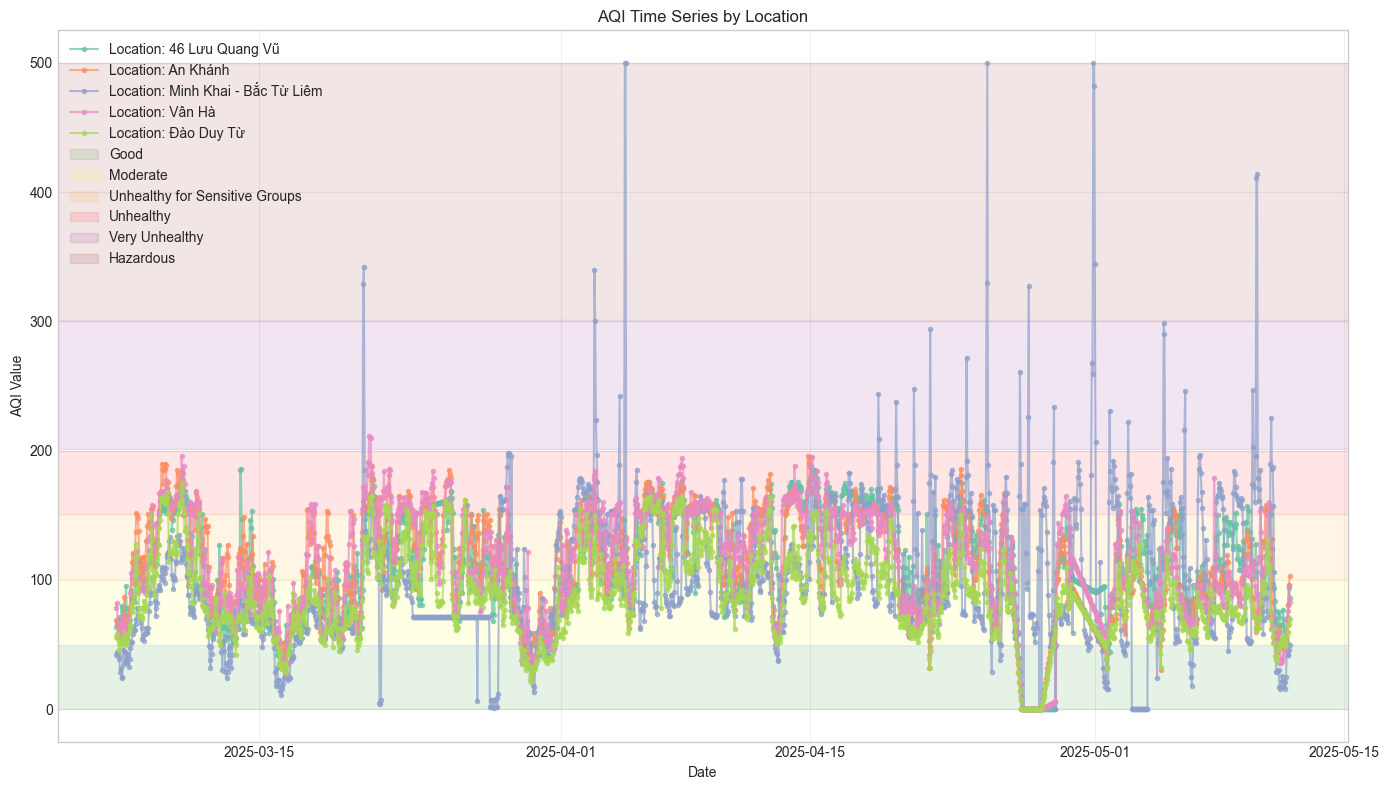

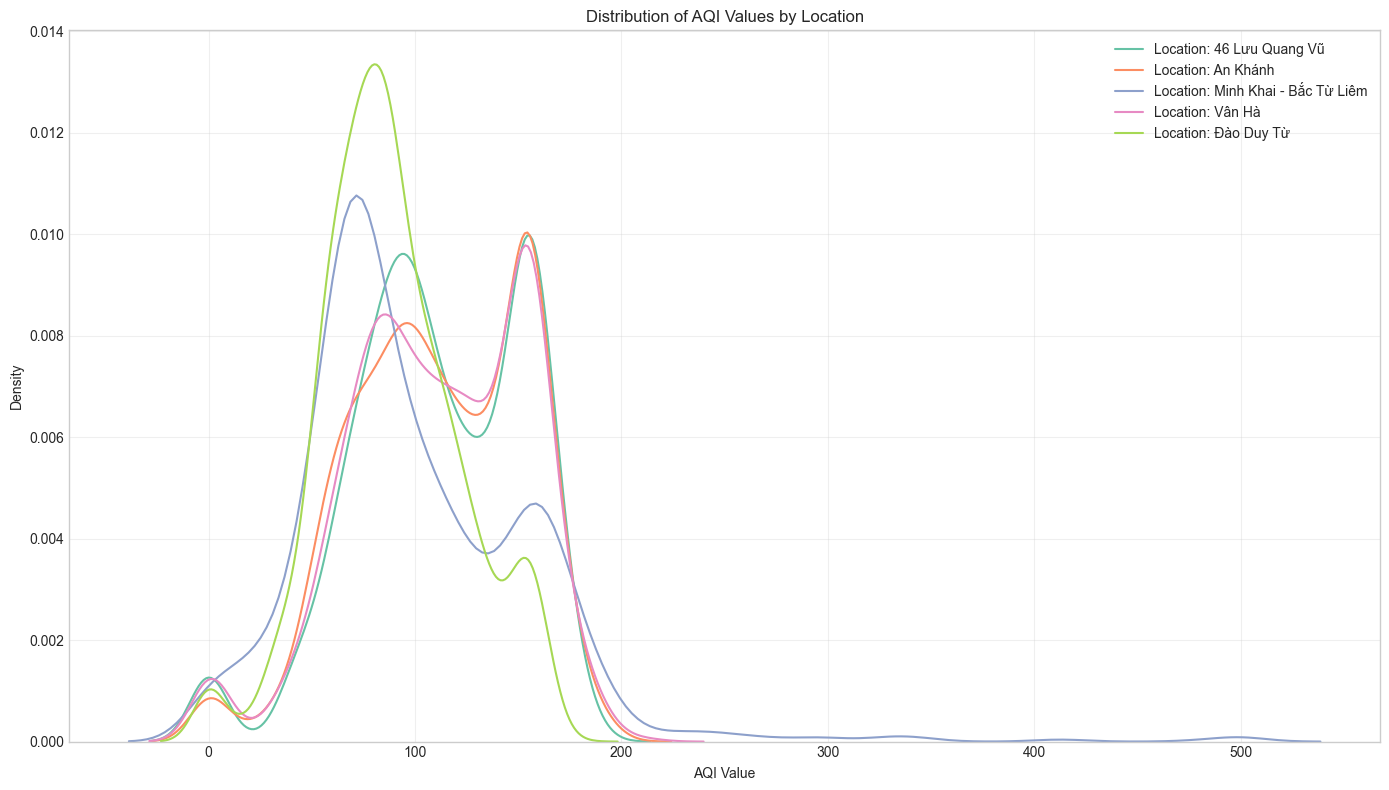

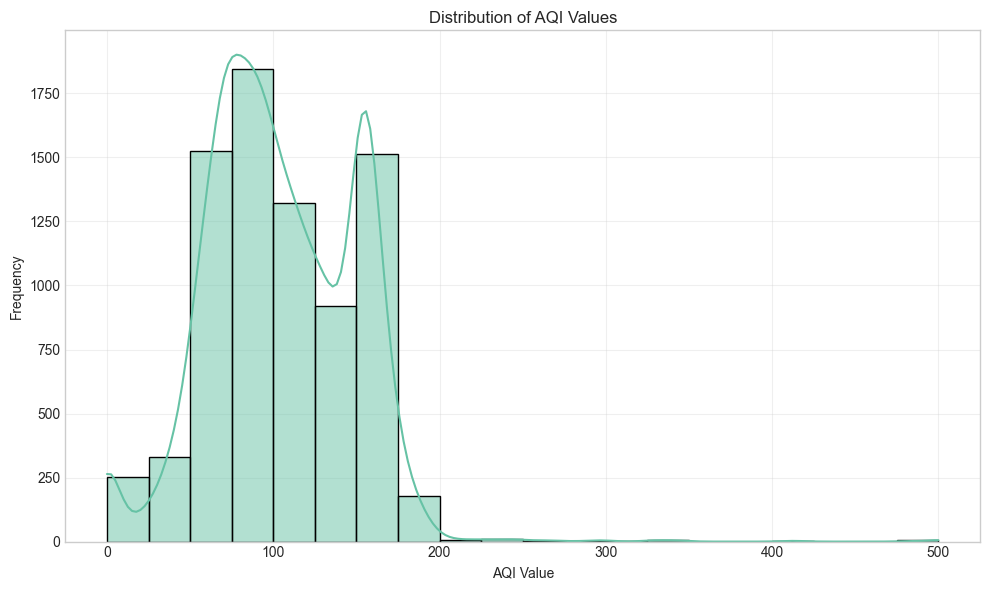

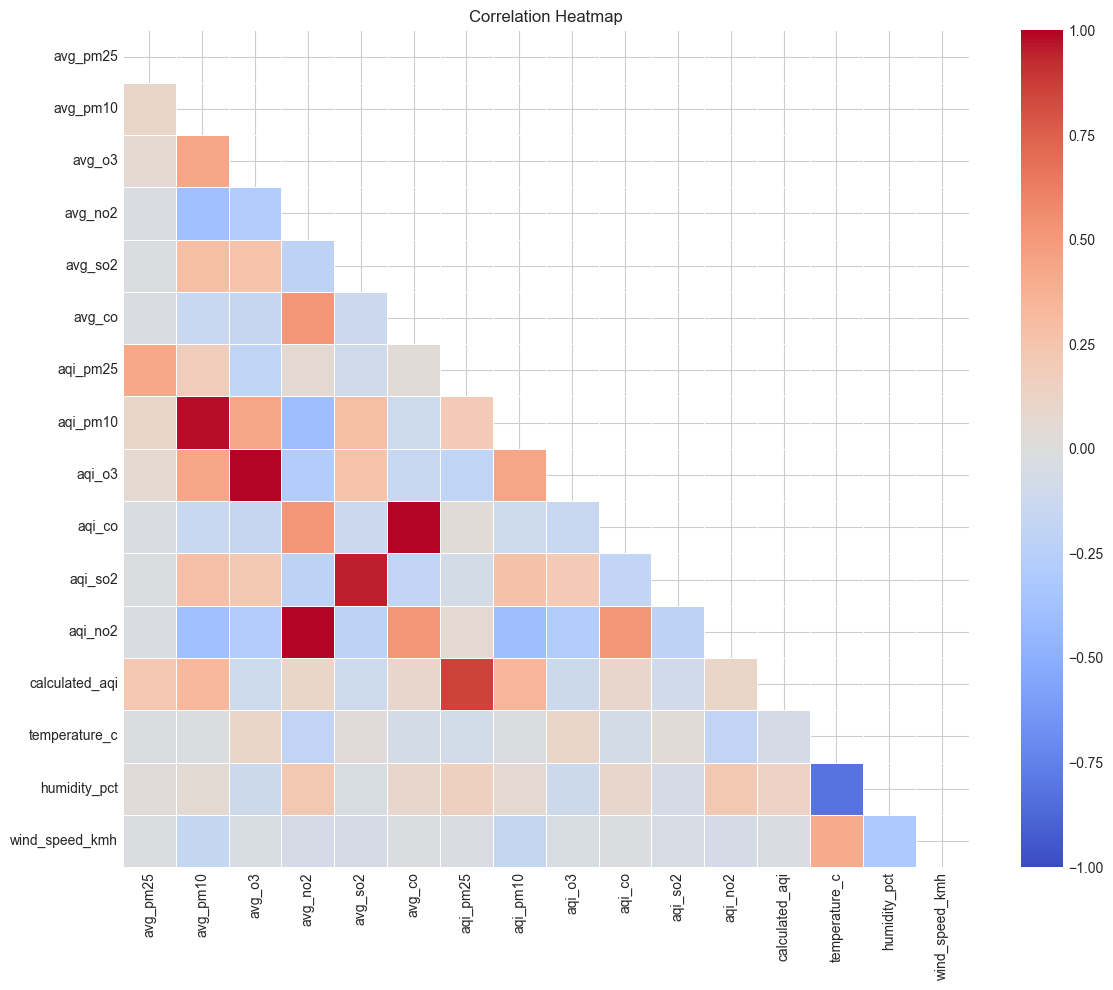

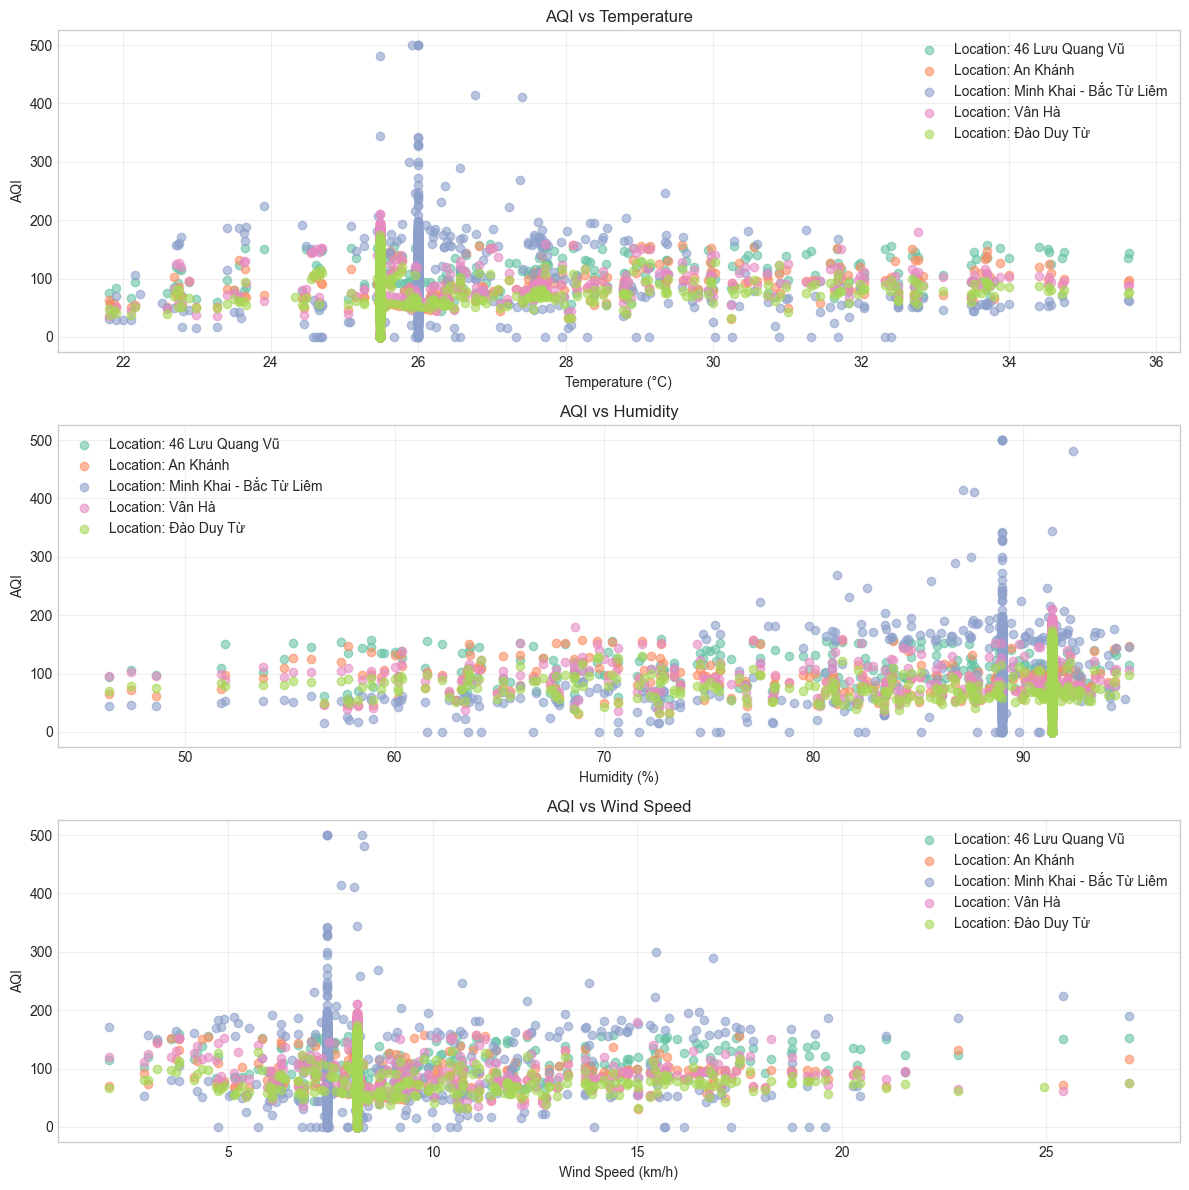

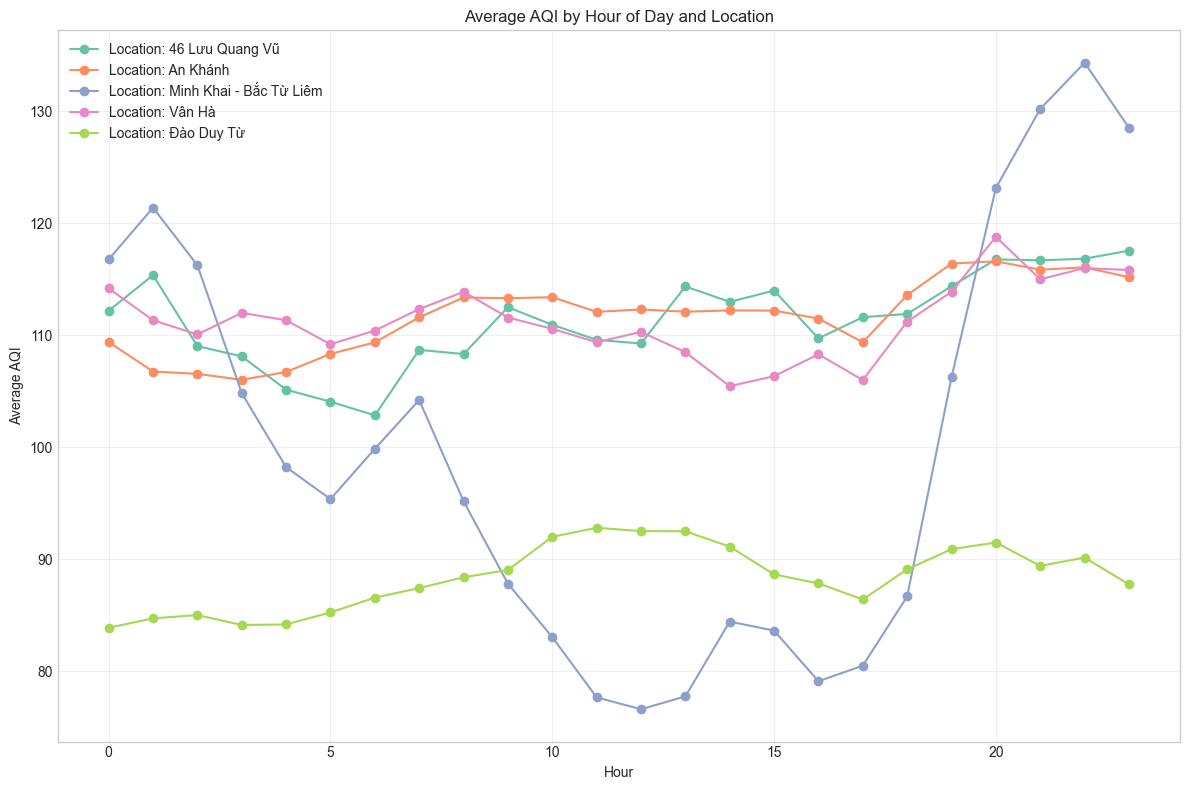

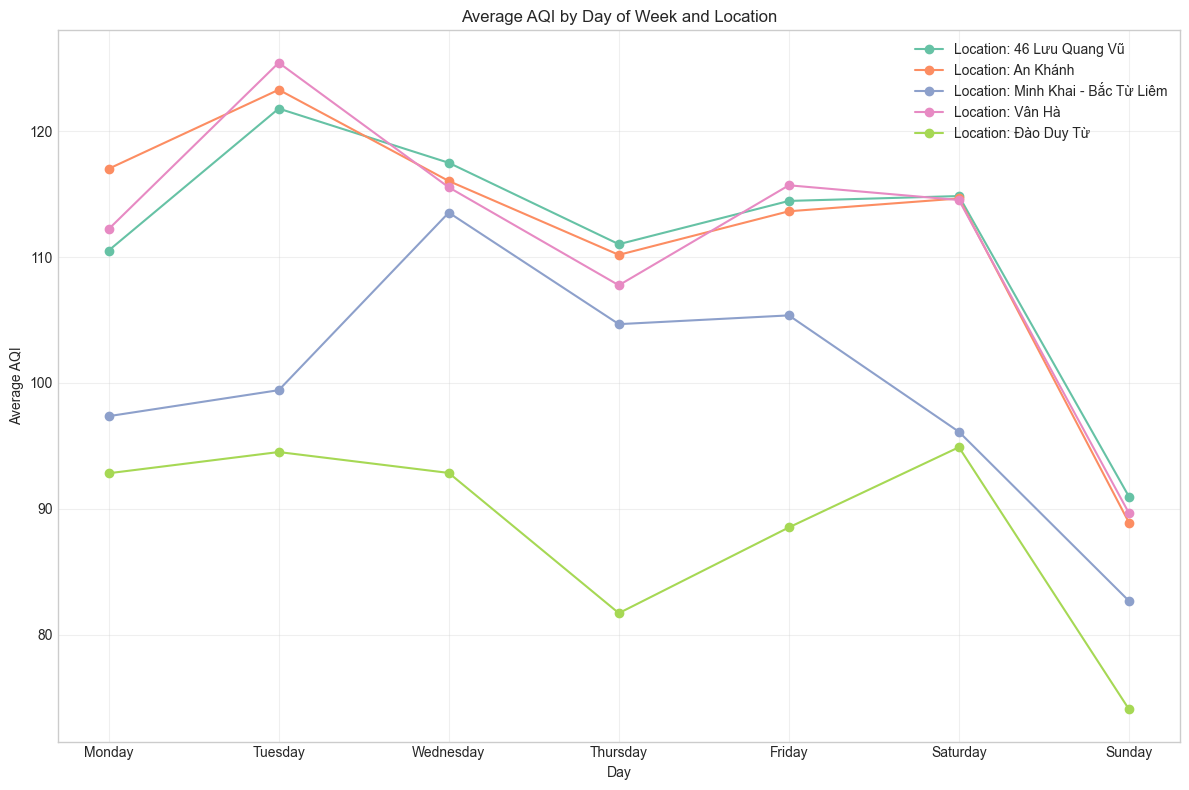

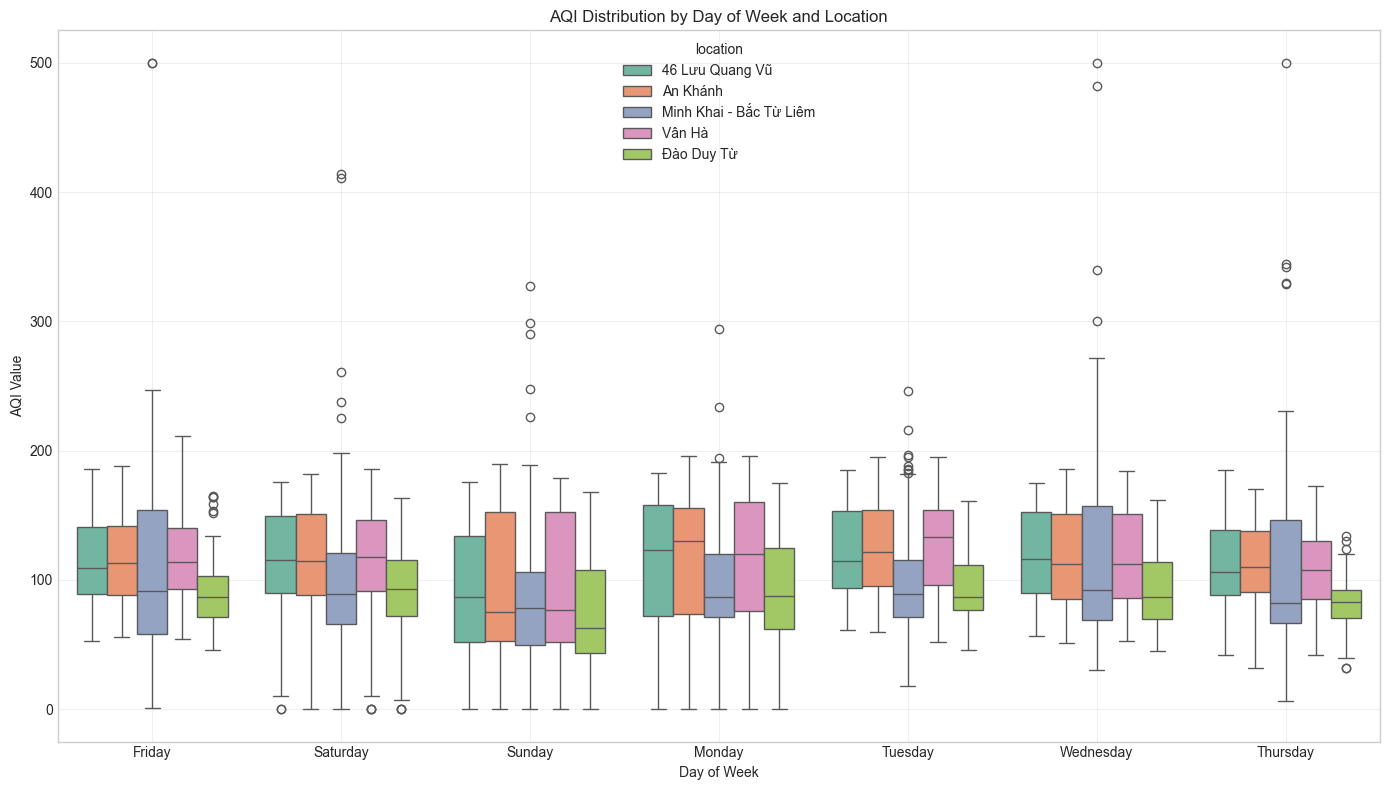

Exploratory data analysis completed.


In [11]:
aq_predictor.exploratory_data_analysis()

### 5.3 Correlation Analysis

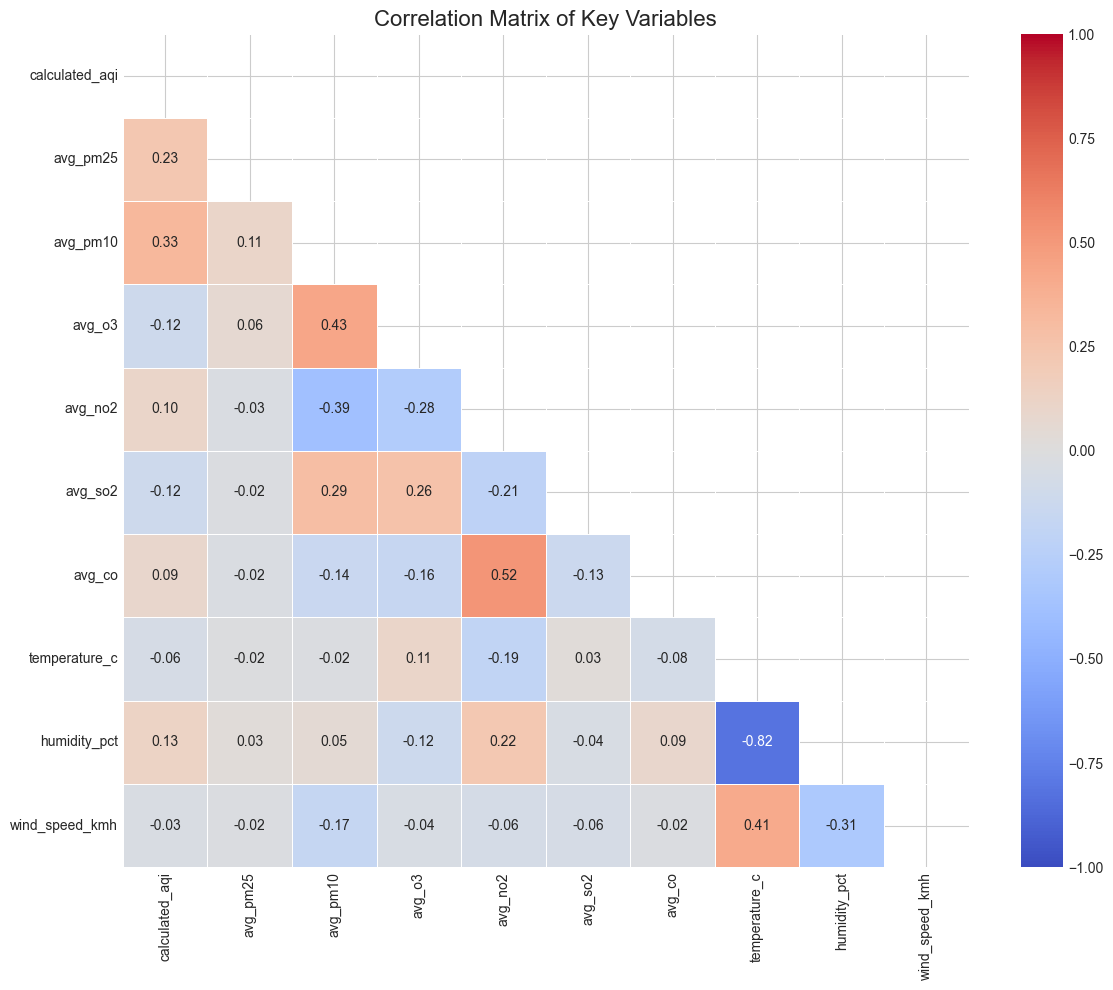

In [12]:
# Correlation heatmap for key variables
if aq_predictor.data is not None:
    # Select important variables for correlation analysis
    key_vars = ['calculated_aqi', 'avg_pm25', 'avg_pm10', 'avg_o3', 'avg_no2', 'avg_so2', 'avg_co', 
                'temperature_c', 'humidity_pct', 'wind_speed_kmh']
    
    # Filter available columns
    available_vars = [var for var in key_vars if var in aq_predictor.data.columns]
    
    # Create correlation matrix
    if available_vars:
        corr_matrix = aq_predictor.data[available_vars].corr()
        
        # Plot heatmap
        plt.figure(figsize=(12, 10))
        mask = np.triu(corr_matrix)
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', 
                    fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
        plt.title('Correlation Matrix of Key Variables', fontsize=16)
        plt.tight_layout()
        plt.show()

### 5.4 AQI Categories Distribution

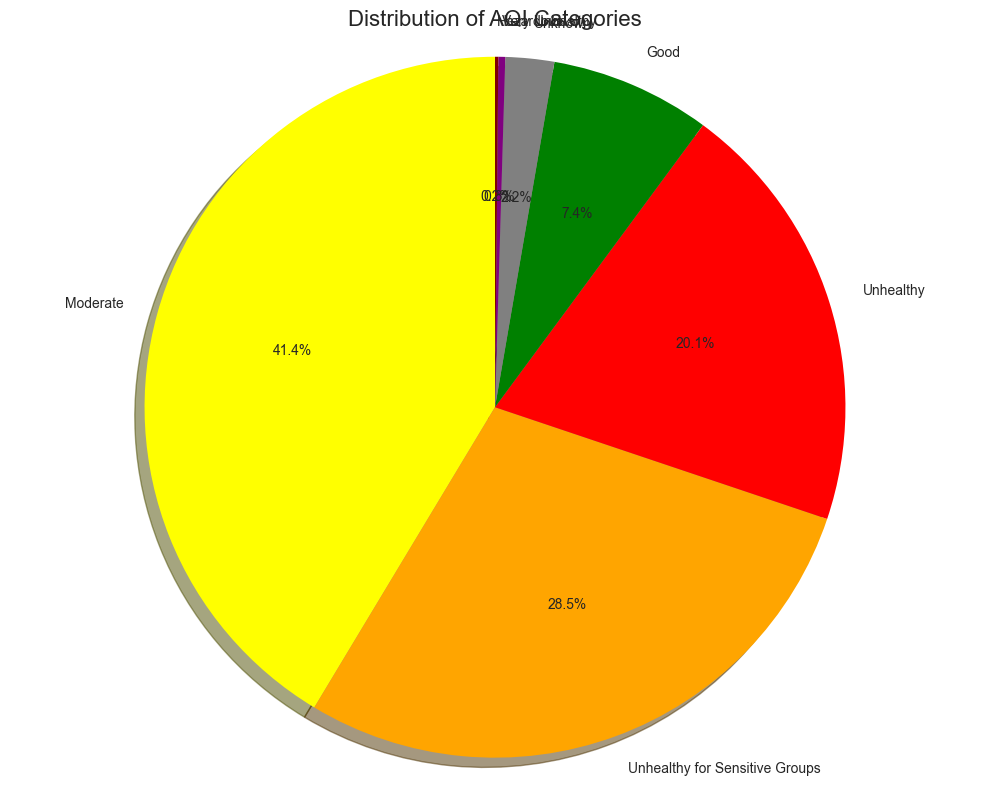

In [13]:
# Analyze AQI categories
if aq_predictor.data is not None and 'aqi_category' in aq_predictor.data.columns:
    aqi_counts = aq_predictor.data['aqi_category'].value_counts()
    
    # Plot pie chart
    plt.figure(figsize=(10, 8))
    plt.pie(aqi_counts, labels=aqi_counts.index, autopct='%1.1f%%', 
            colors=[aq_predictor.aqi_colors.get(cat, 'gray') for cat in aqi_counts.index],
            startangle=90, shadow=True)
    plt.axis('equal')
    plt.title('Distribution of AQI Categories', fontsize=16)
    plt.tight_layout()
    plt.show()

## 6. Prepare Data for Forecasting

Create features for time series forecasting, including lagged variables, time-based features, and rolling averages.

In [14]:
forecast_data = aq_predictor.prepare_data_for_forecasting(target_column='calculated_aqi')

Found 5 locations: ['46 Lưu Quang Vũ' 'An Khánh' 'Minh Khai - Bắc Từ Liêm' 'Vân Hà'
 'Đào Duy Từ']
Preparing forecast data for location: 46 Lưu Quang Vũ
Preparing forecast data for location: An Khánh
Preparing forecast data for location: Minh Khai - Bắc Từ Liêm
Preparing forecast data for location: Vân Hà
Preparing forecast data for location: Đào Duy Từ
Encoded locations as 4 binary features
Added seasonal decomposition features
Prepared time series data with 7068 records and 59 features

Features most correlated with target:
calculated_aqi                    1.000000
calculated_aqi_rolling_3h         0.940759
calculated_aqi_lag_1              0.899545
calculated_aqi_rolling_6h         0.860794
calculated_aqi_trend              0.800381
calculated_aqi_lag_2              0.790905
calculated_aqi_rolling_12h        0.755845
calculated_aqi_lag_3              0.716945
calculated_aqi_rolling_24h        0.682144
calculated_aqi_resid              0.642234
calculated_aqi_rolling_24h_min    0.58

In [15]:
# Display the forecast data shape and first few rows
if aq_predictor.forecast_data is not None:
    print(f"Forecast data shape: {aq_predictor.forecast_data.shape}")
    aq_predictor.forecast_data.head()

Forecast data shape: (7068, 59)


### 6.1 Feature Importance Analysis

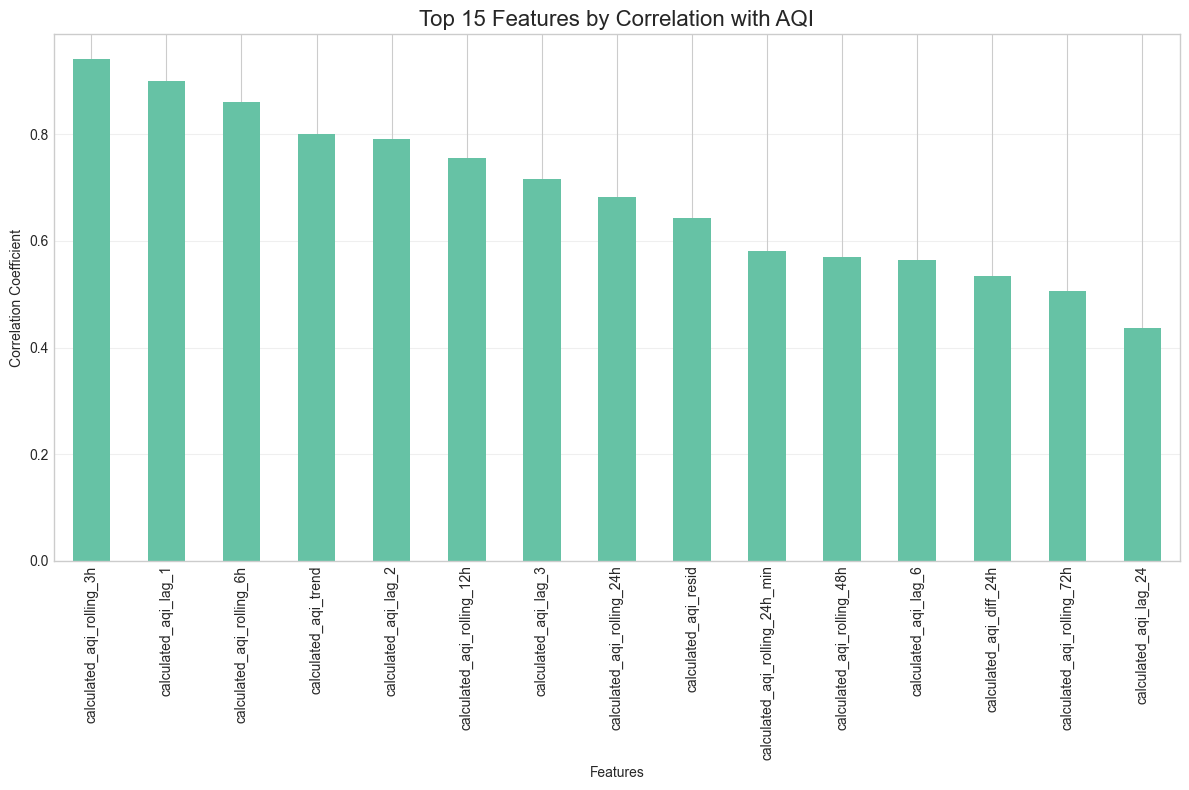

In [16]:
# Analyze features correlation with target
if aq_predictor.forecast_data is not None:
    target_col = 'calculated_aqi'
    correlations = aq_predictor.forecast_data.corr()[target_col].sort_values(ascending=False)
    
    # Plot top 15 correlations
    plt.figure(figsize=(12, 8))
    correlations.drop(target_col).head(15).plot(kind='bar')
    plt.title('Top 15 Features by Correlation with AQI', fontsize=16)
    plt.xlabel('Features')
    plt.ylabel('Correlation Coefficient')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

## 7. Train and Evaluate Models

Train multiple forecasting models and evaluate their performance.

In [17]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test, test_index = aq_predictor.train_test_split(test_size=0.2)

if X_train is not None:
    print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

Original data shape: (7068, 59) from 2025-03-14 00:00:00 to 2025-05-11 23:00:00
Training data: 5654 records from 2025-03-14 00:00:00 to 2025-04-30 02:00:00
Testing data: 1414 records from 2025-04-30 02:00:00 to 2025-05-11 23:00:00
Features used: 51
Training set: (5654, 51), Testing set: (1414, 51)


Splitting data into training and testing sets...
Original data shape: (7068, 59) from 2025-03-14 00:00:00 to 2025-05-11 23:00:00
Training data: 5654 records from 2025-03-14 00:00:00 to 2025-04-30 02:00:00
Testing data: 1414 records from 2025-04-30 02:00:00 to 2025-05-11 23:00:00
Features used: 51
Training set: (5654, 51), Testing set: (1414, 51)

=== Training Machine Learning Models ===

Training Linear Regression...
Linear Regression Performance:
  MAE: 0.00
  RMSE: 0.00
  R²: 1.0000
  MAPE: 0.00%
  Category Accuracy: 99.08%
  Directional Accuracy: 99.01%

  Performance by AQI Category:
    Good (n=116): MAE=0.00, RMSE=0.00
    Hazardous (n=5): MAE=0.00, RMSE=0.00
    Moderate (n=832): MAE=0.00, RMSE=0.00
    Unhealthy (n=123): MAE=0.00, RMSE=0.00
    Unhealthy for Sensitive Groups (n=326): MAE=0.00, RMSE=0.00
    Very Unhealthy (n=12): MAE=0.00, RMSE=0.00


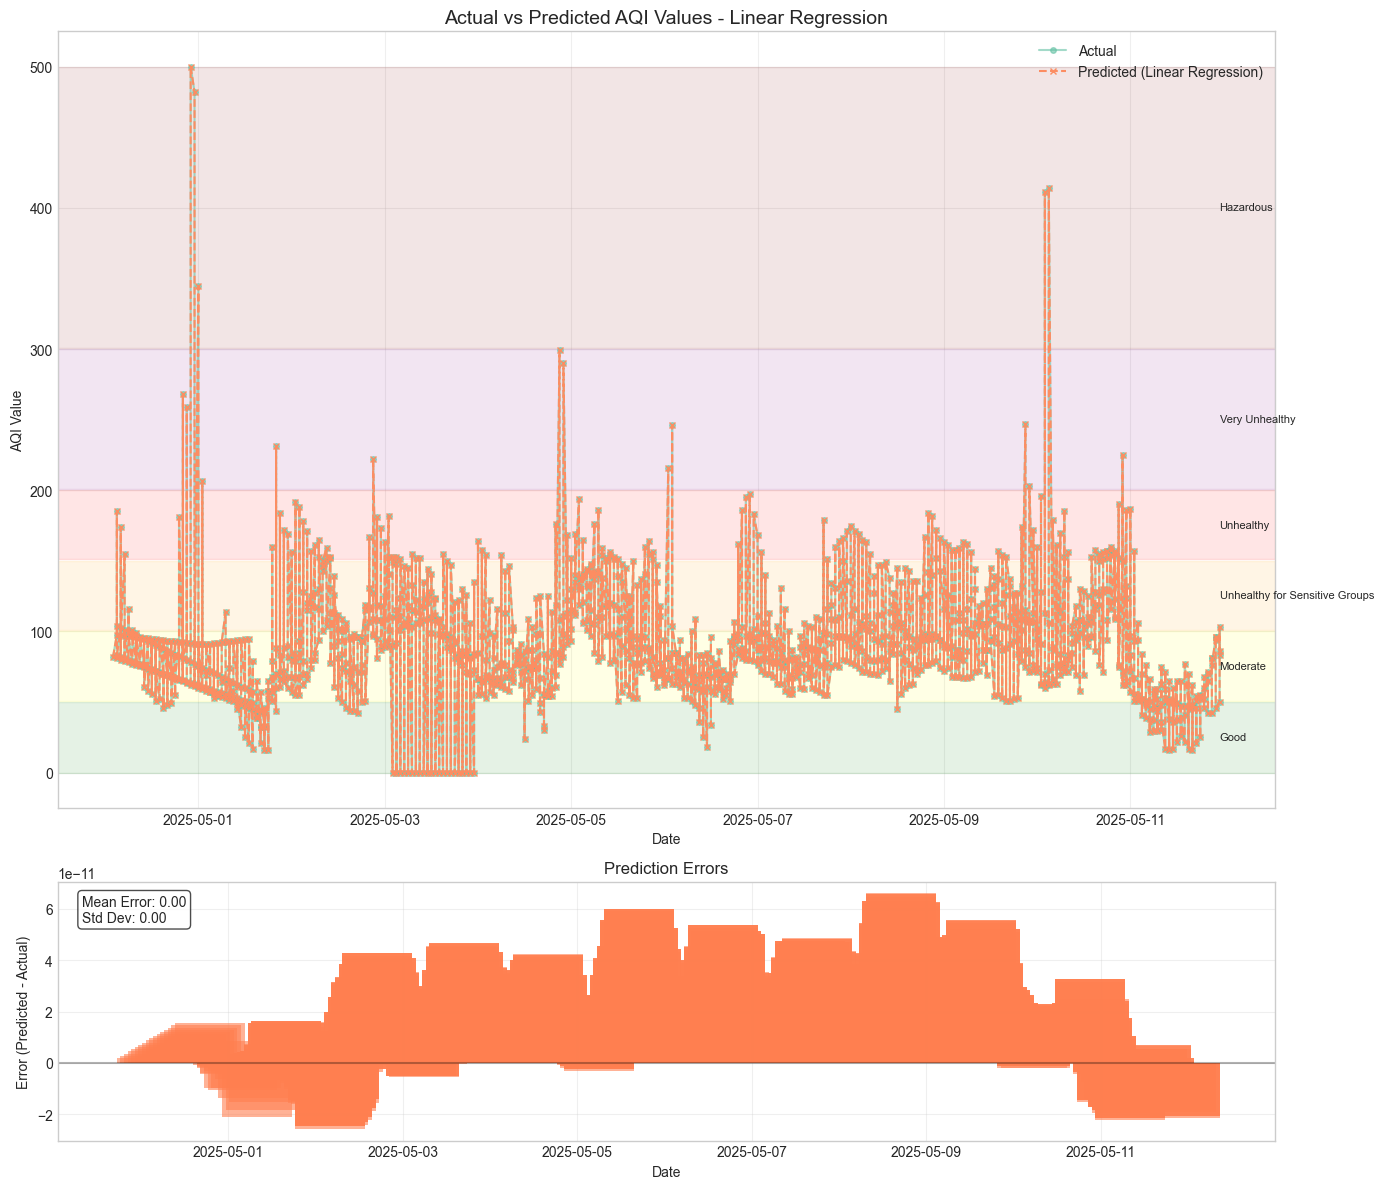

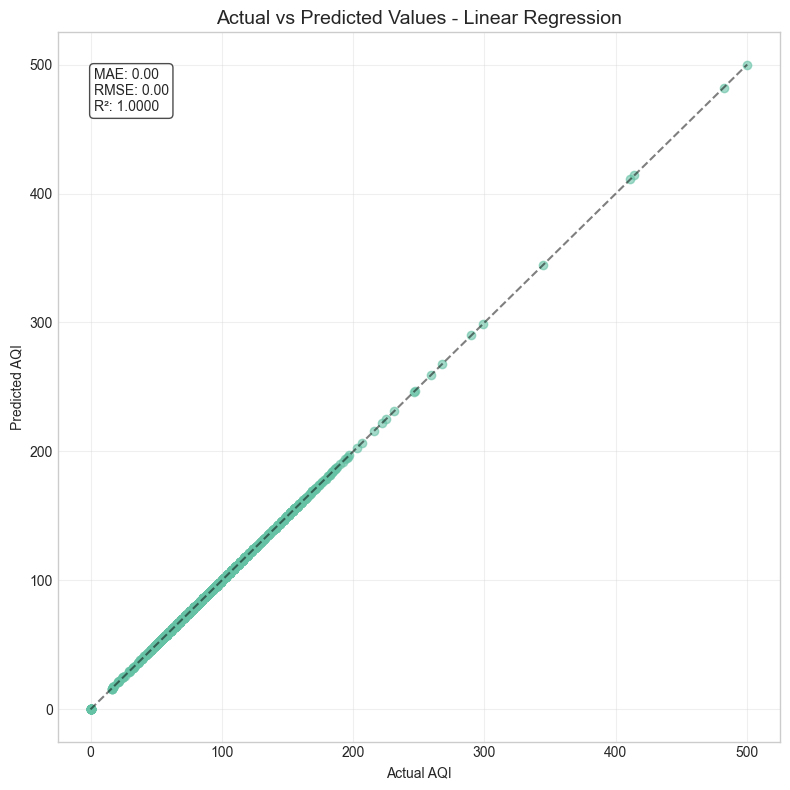

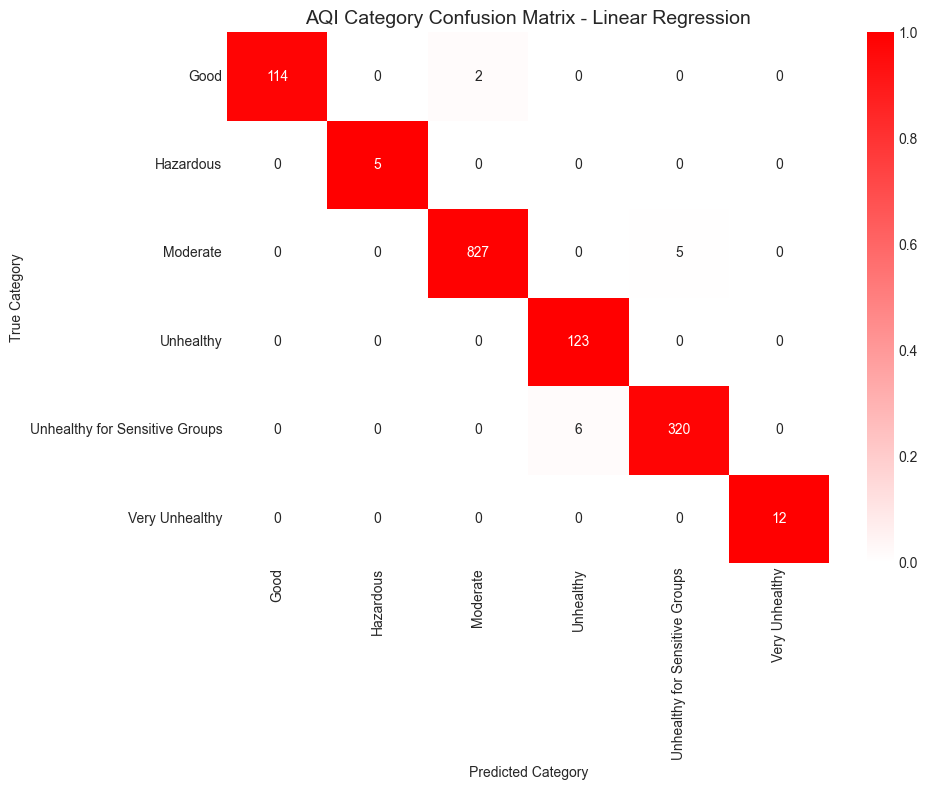


Training Ridge Regression...
Ridge Regression Performance:
  MAE: 2.58
  RMSE: 3.30
  R²: 0.9943
  MAPE: 3.17%
  Category Accuracy: 93.28%
  Directional Accuracy: 98.87%

  Performance by AQI Category:
    Good (n=116): MAE=2.40, RMSE=2.96
    Hazardous (n=5): MAE=0.62, RMSE=0.81
    Moderate (n=832): MAE=2.58, RMSE=3.38
    Unhealthy (n=123): MAE=2.47, RMSE=3.04
    Unhealthy for Sensitive Groups (n=326): MAE=2.77, RMSE=3.36
    Very Unhealthy (n=12): MAE=1.97, RMSE=2.52


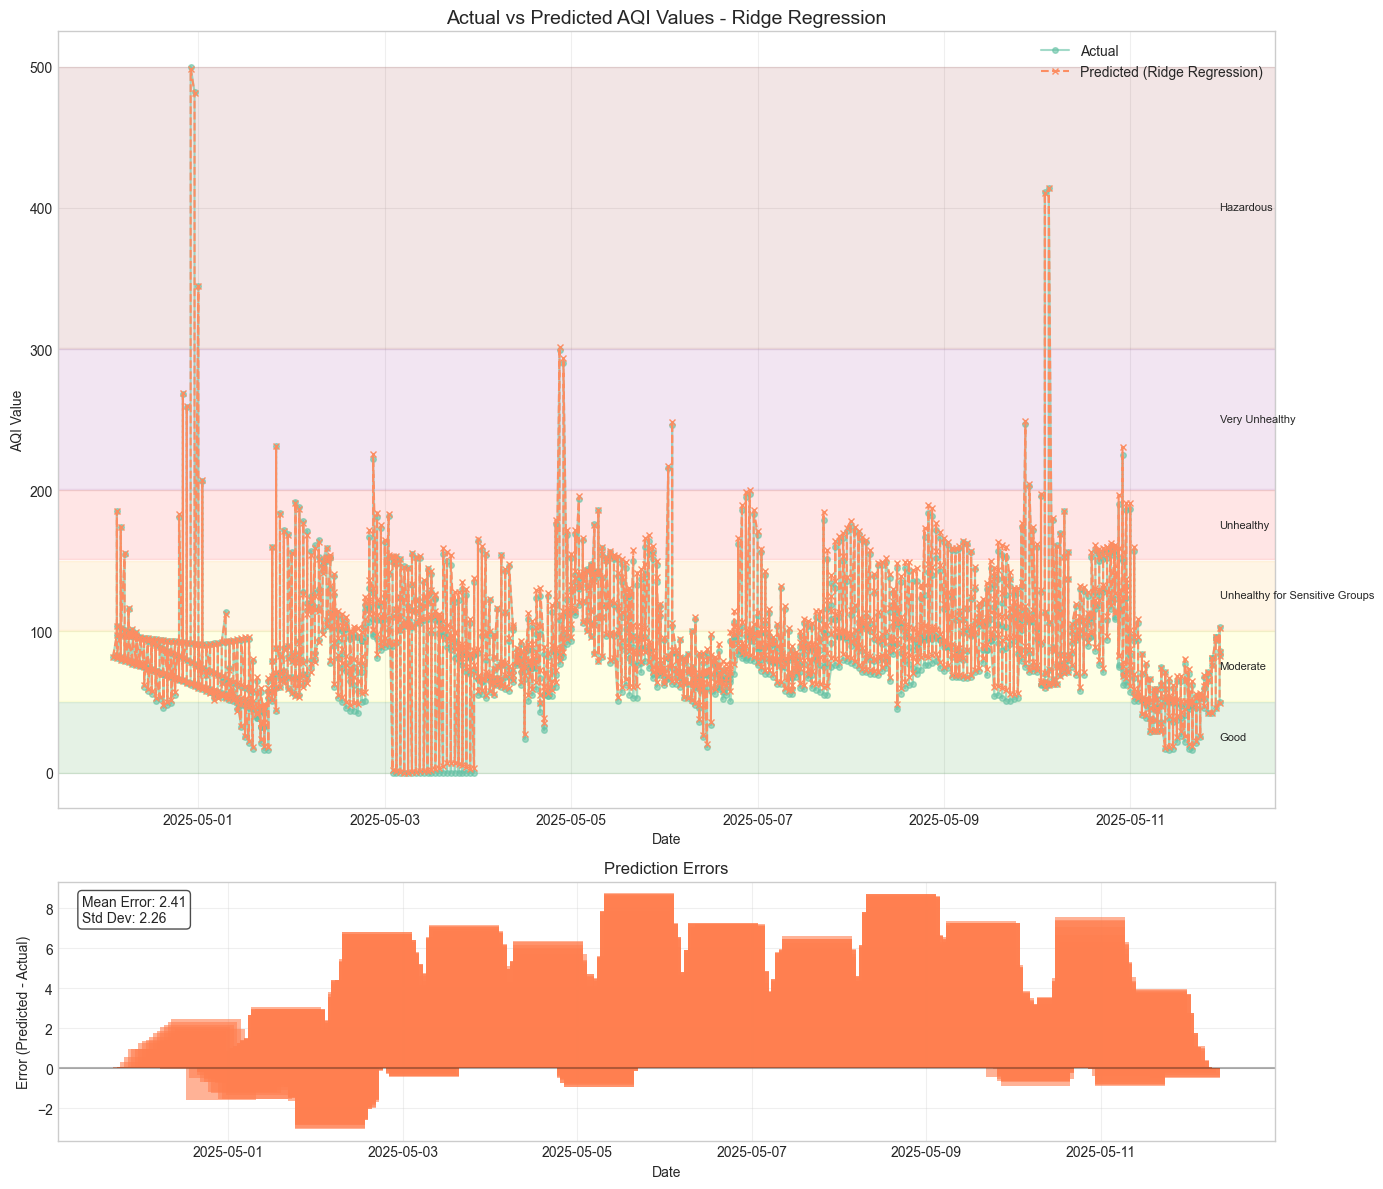

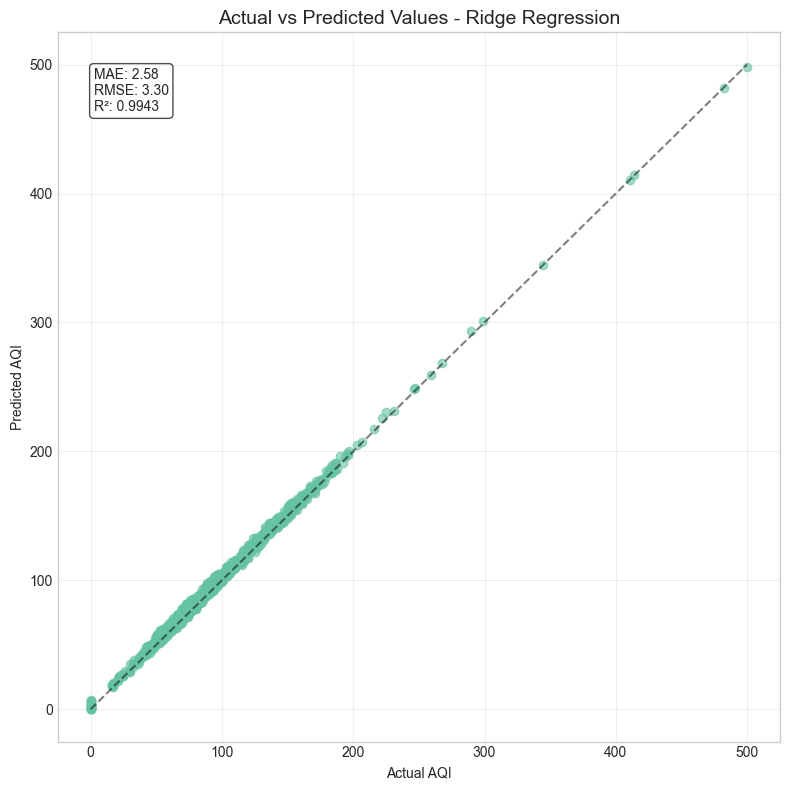

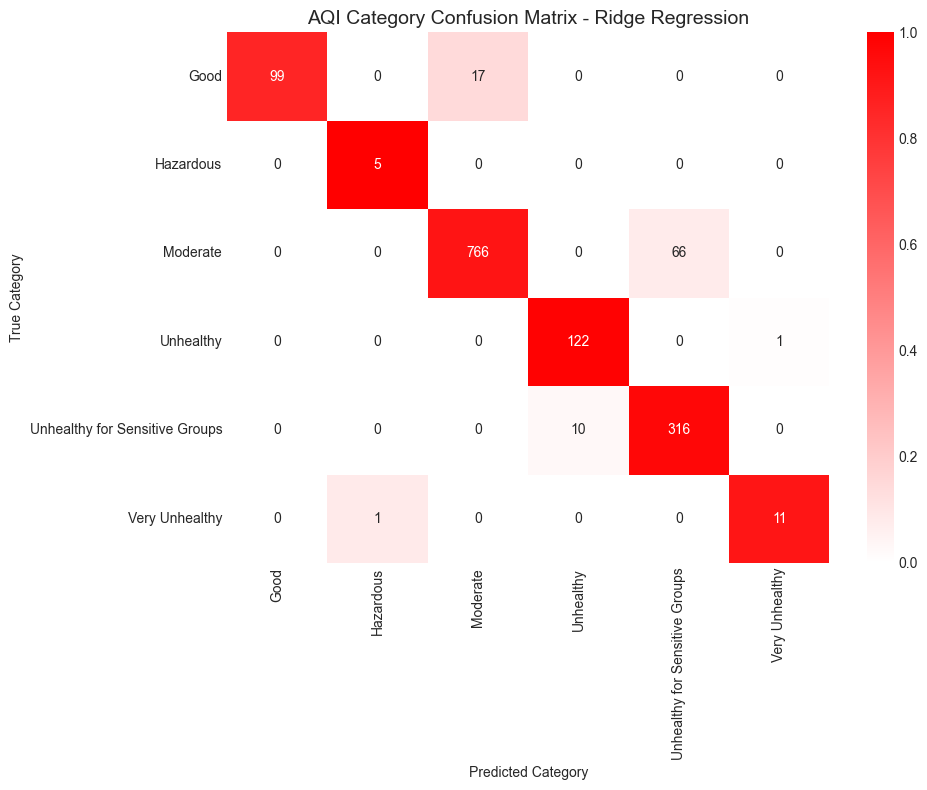


Training Random Forest...
Random Forest Performance:
  MAE: 2.79
  RMSE: 13.86
  R²: 0.8990
  MAPE: 1.84%
  Category Accuracy: 95.62%
  Directional Accuracy: 98.02%

  Performance by AQI Category:
    Good (n=116): MAE=15.84, RMSE=34.15
    Hazardous (n=5): MAE=148.33, RMSE=155.26
    Moderate (n=832): MAE=0.79, RMSE=2.17
    Unhealthy (n=123): MAE=3.09, RMSE=7.18
    Unhealthy for Sensitive Groups (n=326): MAE=0.37, RMSE=1.04
    Very Unhealthy (n=12): MAE=17.37, RMSE=20.54


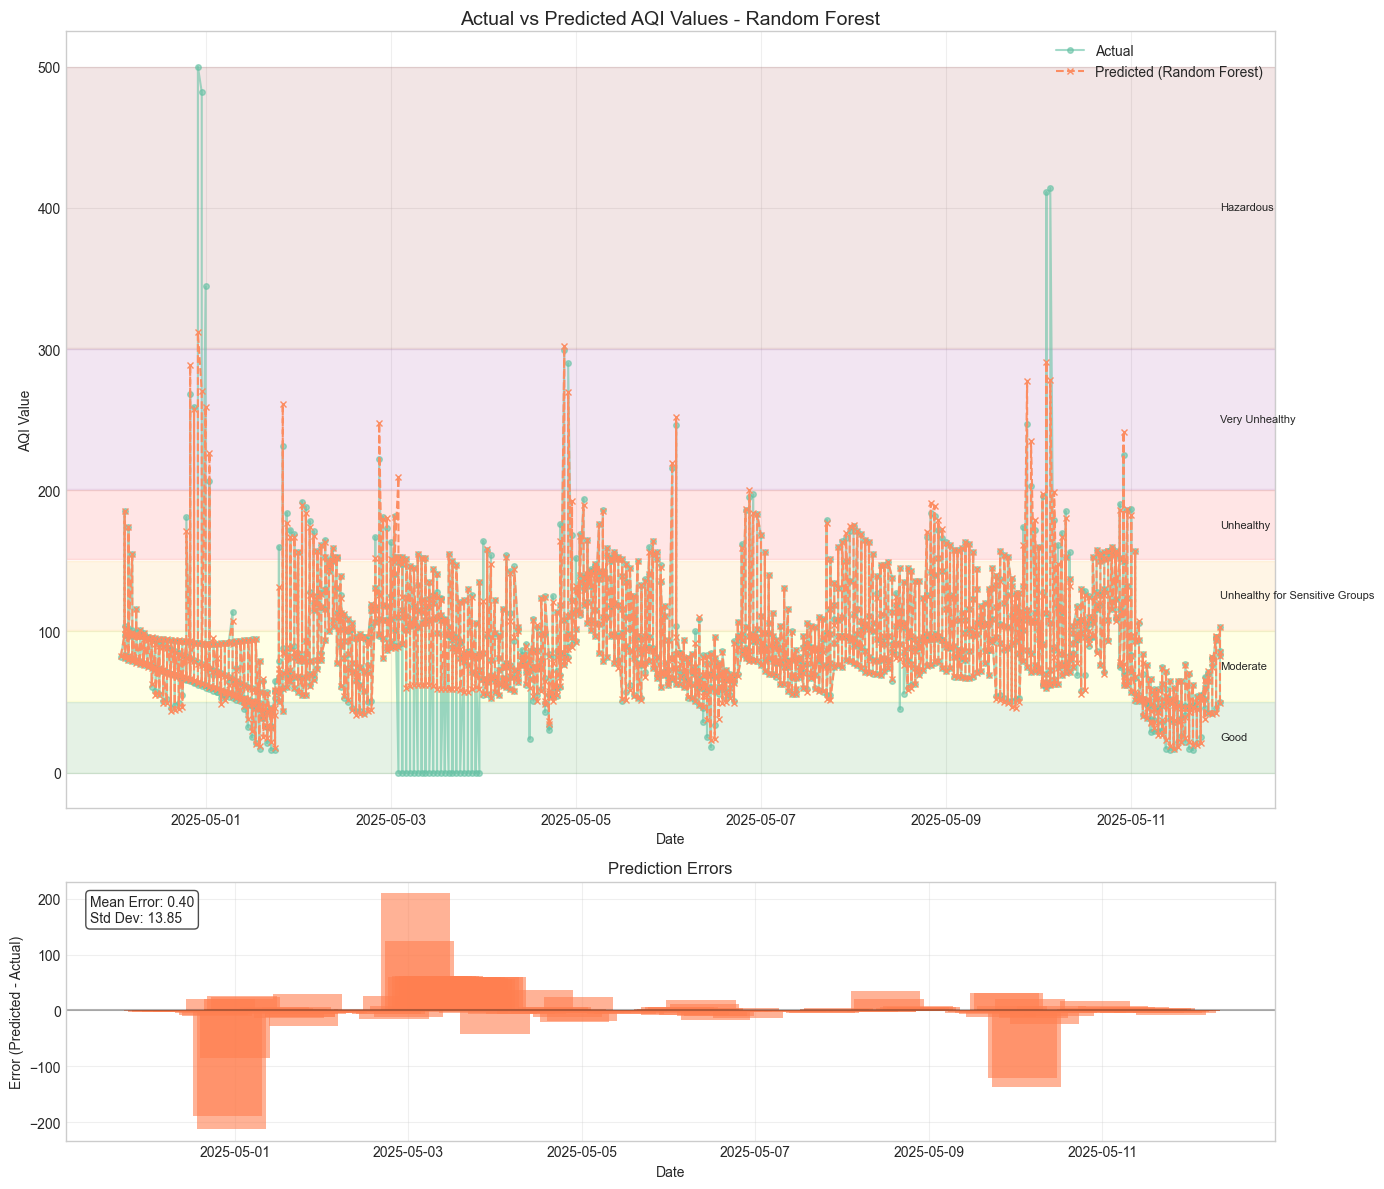

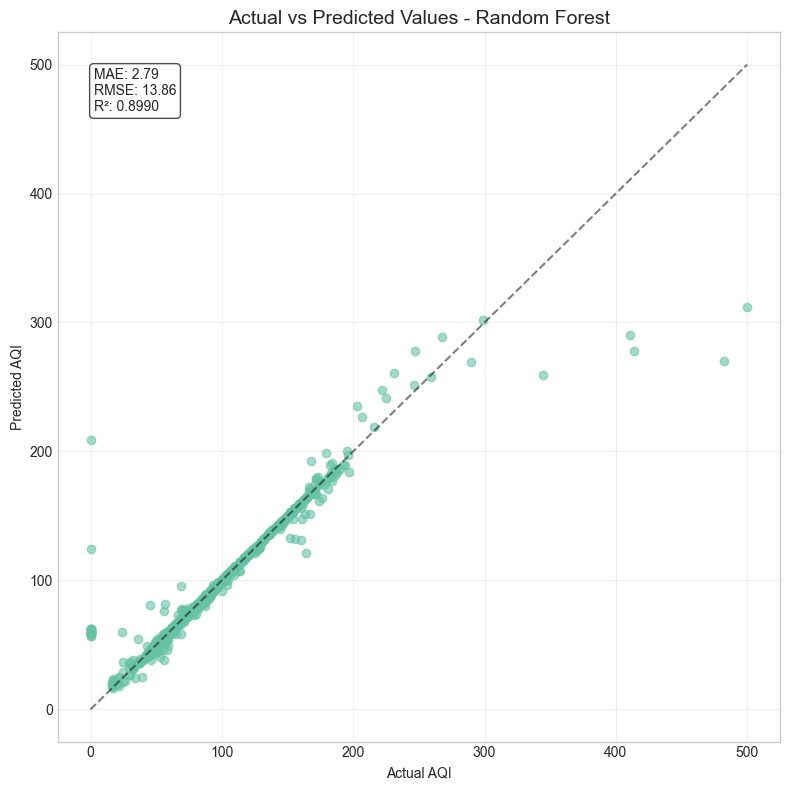

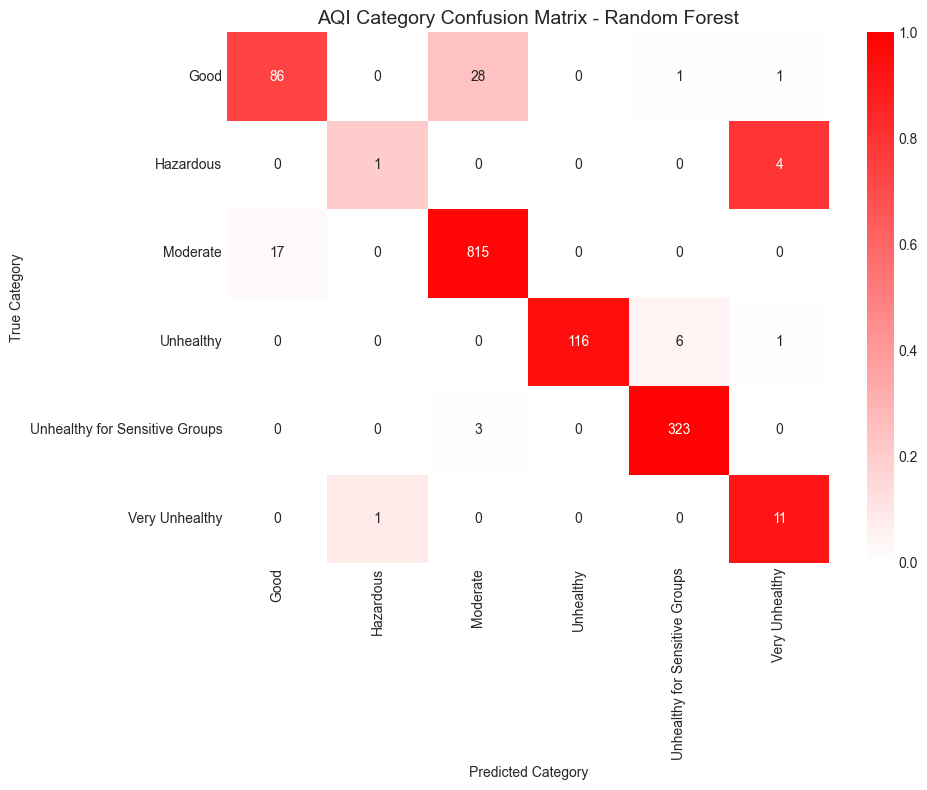


Top 10 important features for Random Forest:
  calculated_aqi_rolling_3h: 0.5456
  avg_pm25: 0.3900
  calculated_aqi_rolling_3h_std: 0.0175
  avg_pm10: 0.0173
  calculated_aqi_lag_2: 0.0035
  avg_o3: 0.0027
  calculated_aqi_rolling_6h_std: 0.0025
  calculated_aqi_lag_168: 0.0022
  calculated_aqi_lag_1: 0.0020
  pm25_pm10_ratio: 0.0017

Training Gradient Boosting...
Gradient Boosting Performance:
  MAE: 4.18
  RMSE: 14.73
  R²: 0.8859
  MAPE: 4.58%
  Category Accuracy: 94.41%
  Directional Accuracy: 95.54%

  Performance by AQI Category:
    Good (n=116): MAE=10.87, RMSE=22.22
    Hazardous (n=5): MAE=182.94, RMSE=202.94
    Moderate (n=832): MAE=2.68, RMSE=3.90
    Unhealthy (n=123): MAE=5.92, RMSE=12.74
    Unhealthy for Sensitive Groups (n=326): MAE=1.77, RMSE=3.54
    Very Unhealthy (n=12): MAE=16.44, RMSE=24.10


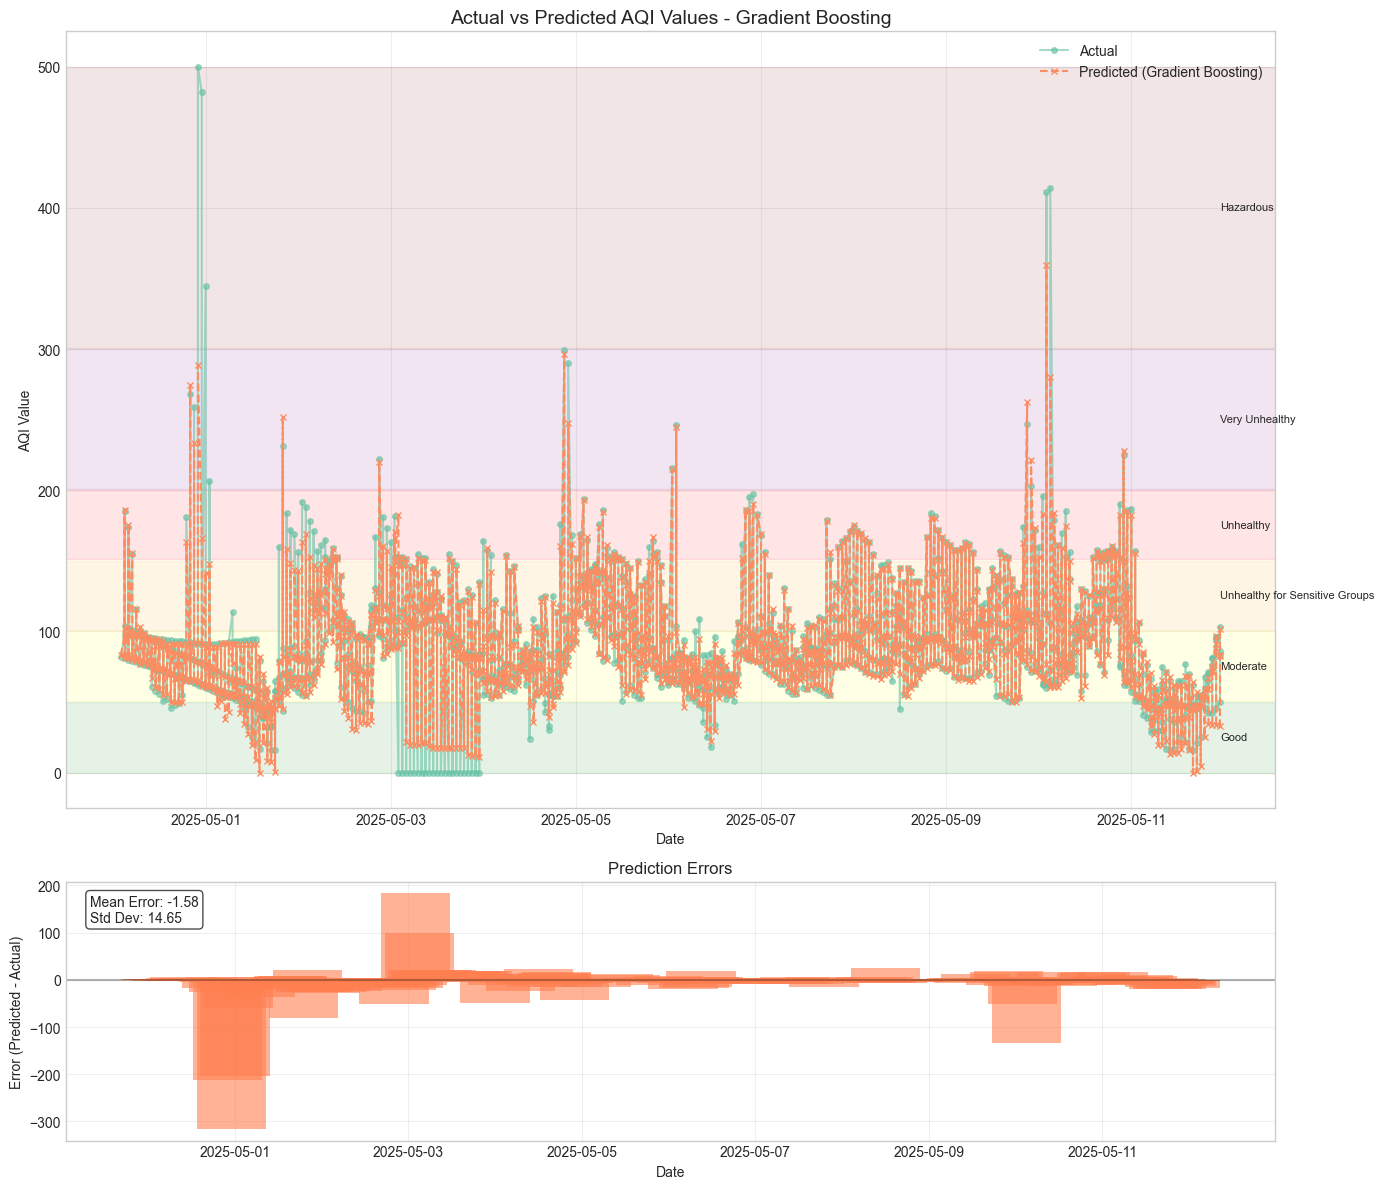

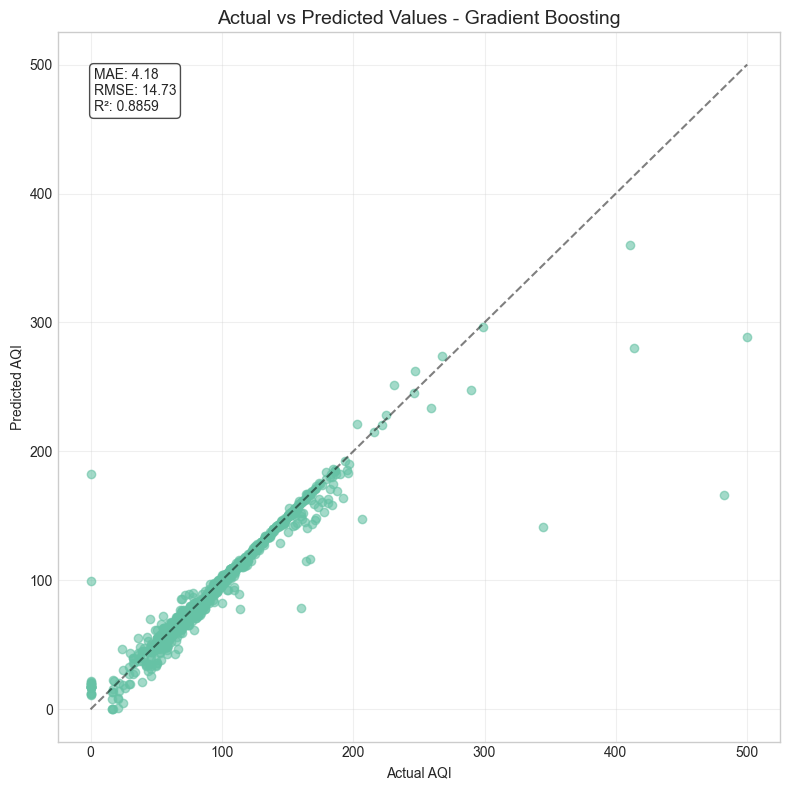

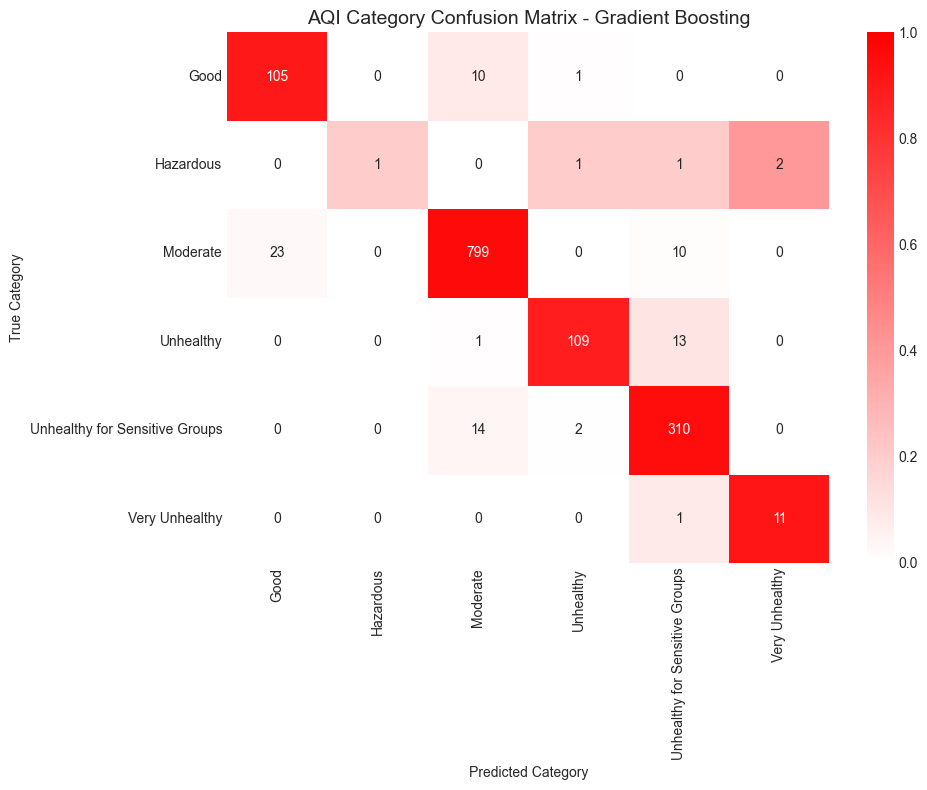


Top 10 important features for Gradient Boosting:
  calculated_aqi_rolling_3h: 0.5804
  avg_pm25: 0.3603
  avg_pm10: 0.0187
  calculated_aqi_lag_2: 0.0149
  calculated_aqi_rolling_3h_std: 0.0142
  calculated_aqi_rolling_12h_std: 0.0019
  avg_o3: 0.0017
  calculated_aqi_rolling_72h: 0.0016
  calculated_aqi_rolling_6h_std: 0.0009
  pm25_pm10_ratio: 0.0006

Training XGBoost...
XGBoost Performance:
  MAE: 2.99
  RMSE: 19.40
  R²: 0.8021
  MAPE: 2.61%
  Category Accuracy: 96.46%
  Directional Accuracy: 97.74%

  Performance by AQI Category:
    Good (n=116): MAE=4.83, RMSE=16.50
    Hazardous (n=5): MAE=286.02, RMSE=295.97
    Moderate (n=832): MAE=1.23, RMSE=2.18
    Unhealthy (n=123): MAE=3.74, RMSE=11.57
    Unhealthy for Sensitive Groups (n=326): MAE=0.85, RMSE=1.46
    Very Unhealthy (n=12): MAE=39.91, RMSE=58.89


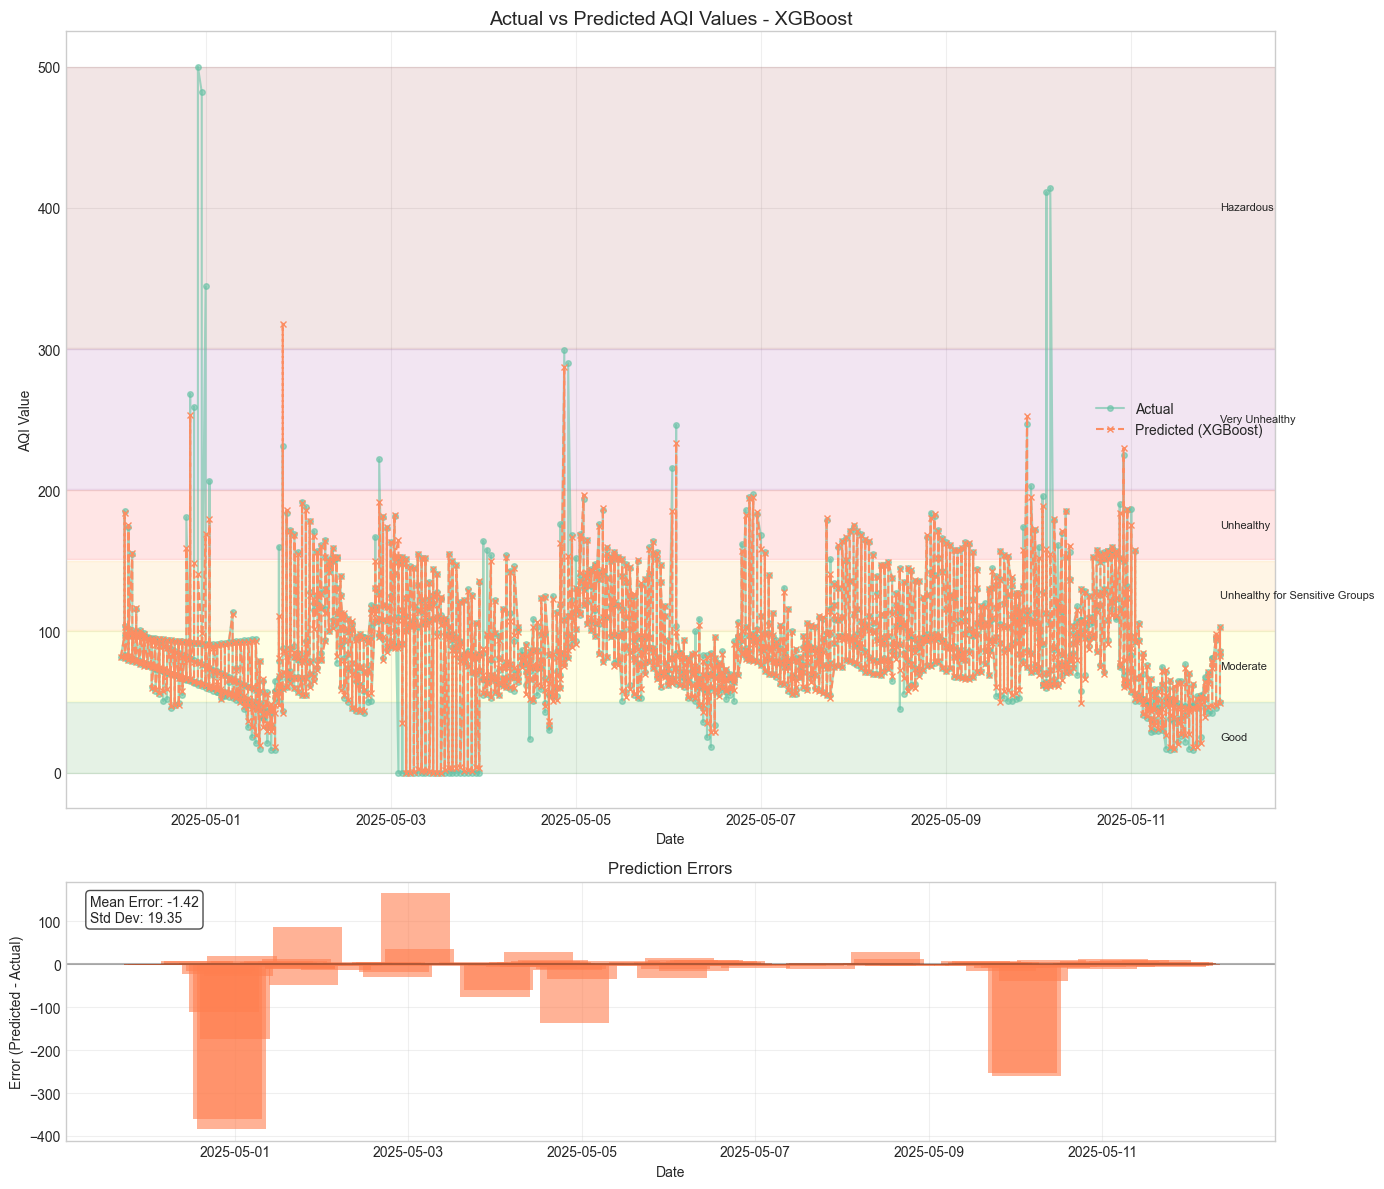

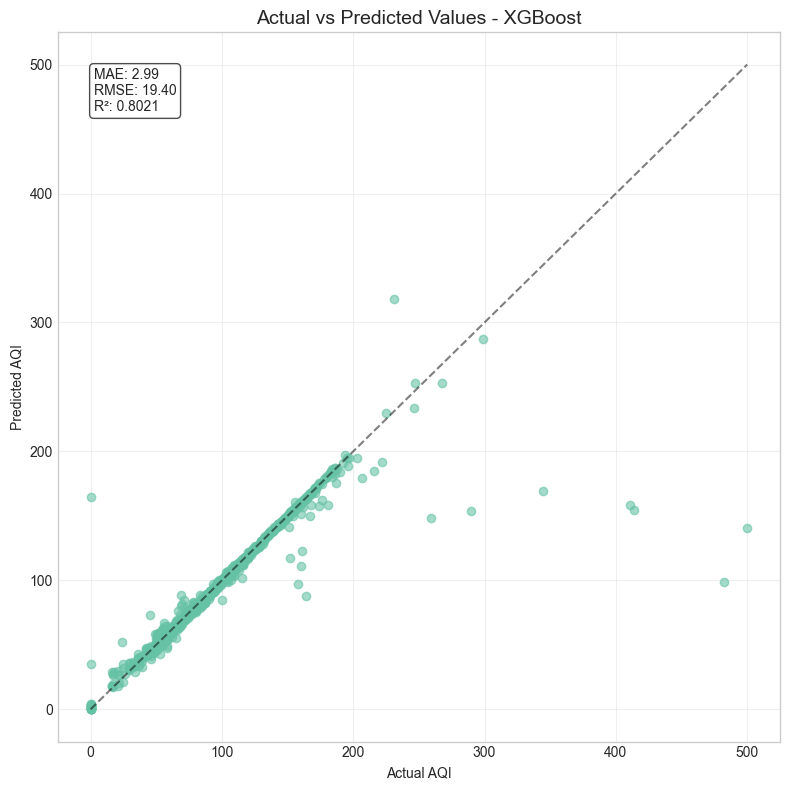

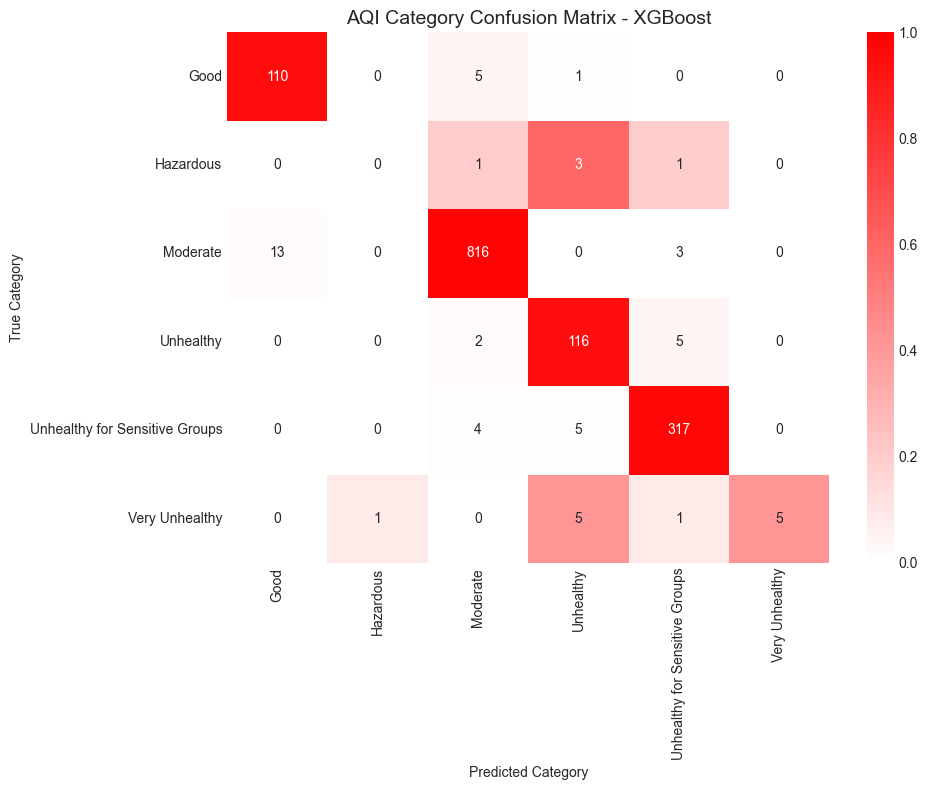


Top 10 important features for XGBoost:
  calculated_aqi_rolling_3h: 0.7894
  avg_pm25: 0.0784
  calculated_aqi_rolling_24h_max: 0.0273
  calculated_aqi_rolling_6h_std: 0.0151
  avg_pm10: 0.0140
  avg_co: 0.0138
  calculated_aqi_lag_2: 0.0137
  pm25_pm10_ratio: 0.0086
  calculated_aqi_rolling_3h_std: 0.0070
  calculated_aqi_lag_168: 0.0050


In [18]:
# Train and evaluate all models
aq_predictor.train_and_evaluate_models()

## 8. Compare Model Performance

Compare the performance of different forecasting models.


Model Comparison:
            model    mae    rmse     r2   mape  category_accuracy  directional_accuracy
Linear Regression 0.0000  0.0000 1.0000 0.0000            99.0806               99.0092
 Ridge Regression 2.5840  3.3033 0.9943 3.1736            93.2815               98.8677
    Random Forest 2.7933 13.8565 0.8990 1.8377            95.6153               98.0184
Gradient Boosting 4.1758 14.7325 0.8859 4.5821            94.4130               95.5414
          XGBoost 2.9907 19.4029 0.8021 2.6116            96.4639               97.7353


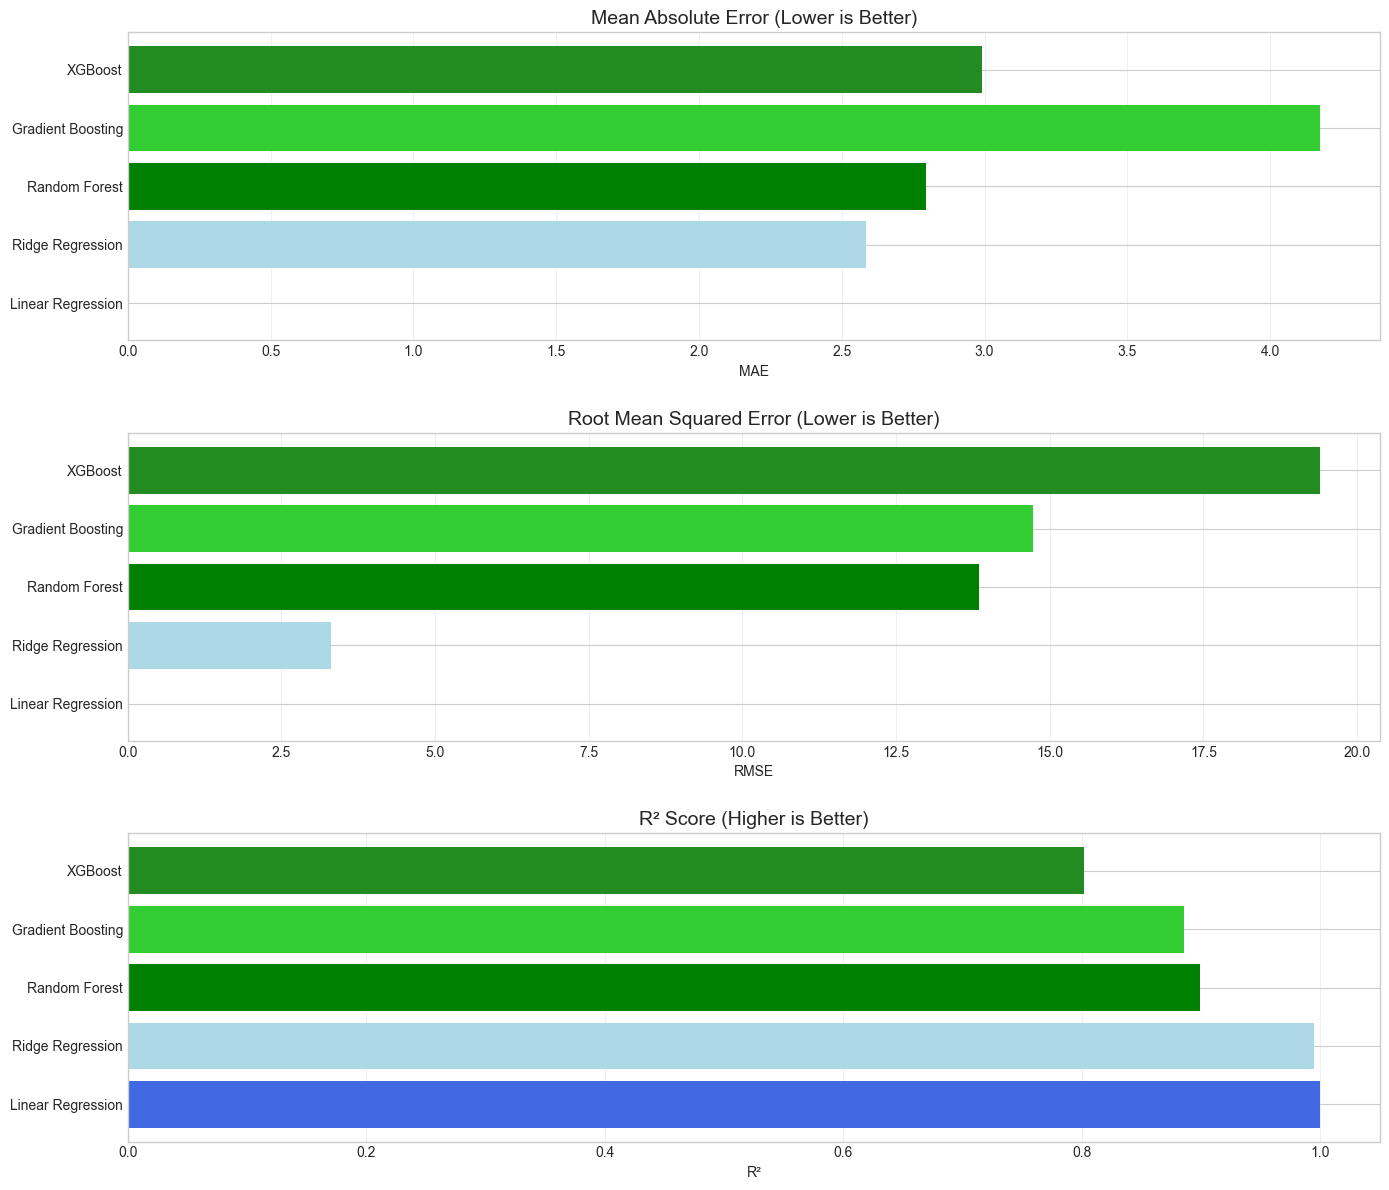

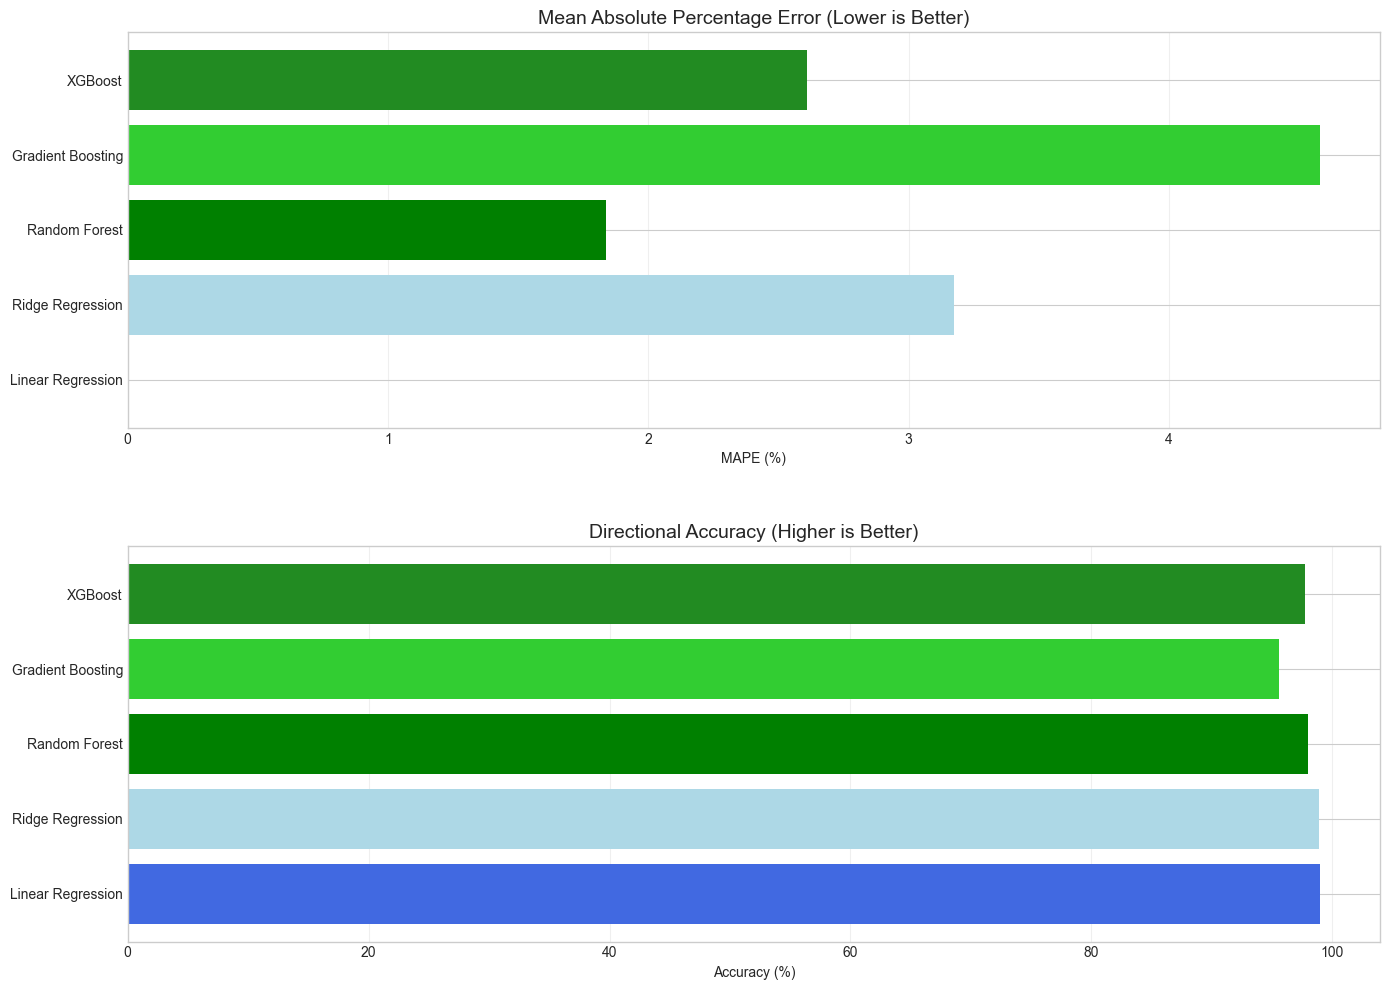

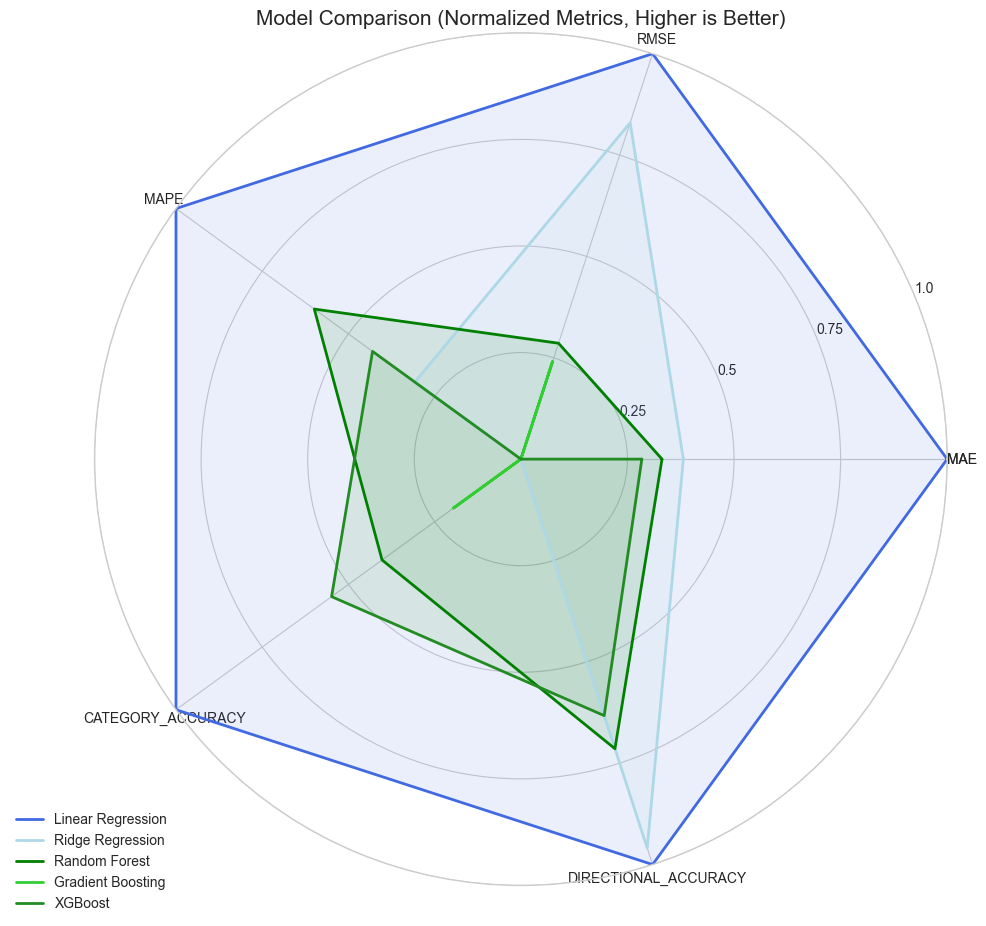


Best performing model based on RMSE: Linear Regression

Completed training and evaluation of all models. Best model: Linear Regression


In [19]:
# Create a performance comparison
best_model = aq_predictor.compare_models()
print(f"\nCompleted training and evaluation of all models. Best model: {best_model}")


In [20]:
# Display model metrics as a table
if aq_predictor.model_results:
    results_df = pd.DataFrame(aq_predictor.model_results).sort_values('rmse')
    display(results_df)

model           mae          rmse        r2          mape  \
0  Linear Regression  1.918296e-11  2.439788e-11  1.000000  2.312818e-11   
1   Ridge Regression  2.584018e+00  3.303342e+00  0.994263  3.173630e+00   
2      Random Forest  2.793306e+00  1.385649e+01  0.899047  1.837724e+00   
3  Gradient Boosting  4.175756e+00  1.473245e+01  0.885879  4.582132e+00   
4            XGBoost  2.990721e+00  1.940288e+01  0.802054  2.611642e+00   

   category_accuracy  directional_accuracy  \
0          99.080622             99.009200   
1          93.281471             98.867657   
2          95.615276             98.018401   
3          94.413013             95.541401   
4          96.463932             97.735315   

                                     category_errors  
0  {'Good': {'count': 116, 'mae': 1.4383038821255...  
1  {'Good': {'count': 116, 'mae': 2.3970849772404...  
2  {'Good': {'count': 116, 'mae': 15.843433384522...  
3  {'Good': {'count': 116, 'mae': 10.869575480393...  
4  {'Good': {'count': 116, 'mae': 4.8334884285612...

## 9. Forecast Future Air Quality

Generate a forecast for the next 24 hours using the best model.

In [21]:
# Find the best model based on RMSE (lower is better)
if aq_predictor.model_results:
    best_model = min(aq_predictor.model_results, key=lambda x: x['rmse'])
    print(f"Best model: {best_model['model']} with RMSE: {best_model['rmse']:.2f}, MAE: {best_model['mae']:.2f}, R²: {best_model['r2']:.4f}")
    
    # Generate forecast using the best model
    forecast_df = aq_predictor.forecast_future(model_name=best_model['model'], steps=24)
else:
    print("No model results available. Using XGBoost as default.")
    forecast_df = aq_predictor.forecast_future(model_name="XGBoost", steps=24)

Best model: Linear Regression with RMSE: 0.00, MAE: 0.00, R²: 1.0000
Generating features for future forecast using Linear Regression...


In [22]:
# Display the forecast
if forecast_df is not None:
    display(forecast_df)

forecasted_aqi  lower_bound  upper_bound
2025-05-11 12:00:00       49.500000    49.500000    49.500000
2025-05-11 13:00:00       49.250000    49.250000    49.250000
2025-05-11 14:00:00       49.375000    49.375000    49.375000
2025-05-11 15:00:00       49.312500    49.312500    49.312500
2025-05-11 16:00:00       49.343750    49.343750    49.343750
2025-05-11 17:00:00       49.328125    49.328125    49.328125
2025-05-11 18:00:00       49.335937    49.335937    49.335938
2025-05-11 19:00:00       49.332031    49.332031    49.332031
2025-05-11 20:00:00       49.333984    49.333984    49.333984
2025-05-11 21:00:00       49.333008    49.333008    49.333008
2025-05-11 22:00:00       49.333496    49.333496    49.333496
2025-05-11 23:00:00       49.333252    49.333252    49.333252
2025-05-12 00:00:00       49.333374    49.333374    49.333374
2025-05-12 01:00:00       49.333313    49.333313    49.333313
2025-05-12 02:00:00       49.333344    49.333344    49.333344
2025-05-12 03:00:00       49.333328    49.333328    49.333328
2025-05-12 04:00:00       49.333336    49.333336    49.333336
2025-05-12 05:00:00       49.333332    49.333332    49.333332
2025-05-12 06:00:00       49.333334    49.333334    49.333334
2025-05-12 07:00:00       49.333333    49.333333    49.333333
2025-05-12 08:00:00       49.333333    49.333333    49.333333
2025-05-12 09:00:00       49.333333    49.333333    49.333333
2025-05-12 10:00:00       49.333333    49.333333    49.333333
2025-05-12 11:00:00       49.333333    49.333333    49.333333

### 9.1 AQI Category Forecasts

Forecasted AQI Categories for next 24 hours:


aqi_category  hours
0         Good     24

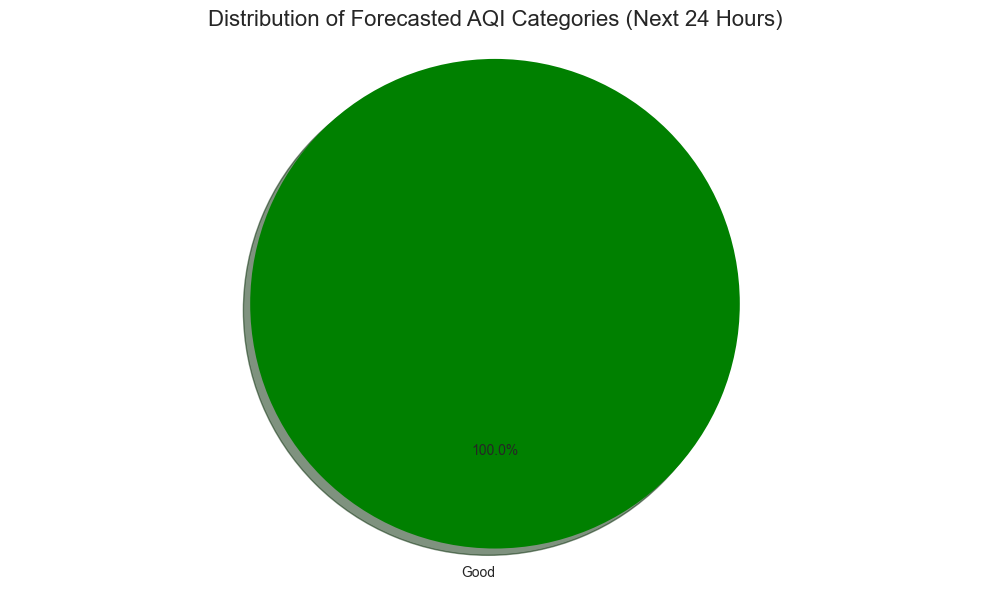

In [23]:
# Convert numeric AQI forecasts to AQI categories
if forecast_df is not None:
    forecast_df['aqi_category'] = forecast_df['forecasted_aqi'].apply(aq_predictor.get_aqi_category)
    
    # Display forecasted categories
    forecast_categories = forecast_df.groupby('aqi_category').size().reset_index(name='hours')
    print("Forecasted AQI Categories for next 24 hours:")
    display(forecast_categories)
    
    # Visualize category distribution
    plt.figure(figsize=(10, 6))
    plt.pie(forecast_categories['hours'], labels=forecast_categories['aqi_category'], autopct='%1.1f%%',
            colors=[aq_predictor.aqi_colors.get(cat, 'gray') for cat in forecast_categories['aqi_category']],
            shadow=True, startangle=90)
    plt.axis('equal')
    plt.title('Distribution of Forecasted AQI Categories (Next 24 Hours)', fontsize=16)
    plt.tight_layout()
    plt.show()

## 10. Save Trained Models

Save the trained models for future use.

In [24]:
aq_predictor.save_models(output_dir='models')

Saved model 'Linear Regression' to models/Linear_Regression.pkl
Saved model 'Ridge Regression' to models/Ridge_Regression.pkl
Saved model 'Random Forest' to models/Random_Forest.pkl
Saved model 'Gradient Boosting' to models/Gradient_Boosting.pkl
Saved model 'XGBoost' to models/XGBoost.pkl
Saved model metadata to models/model_metadata.json


True

## 11. Compare Different Forecast Horizons

In [25]:
# Generate forecasts for different time horizons
horizons = [6, 12, 24, 48]

if aq_predictor.model_results:
    best_model = min(aq_predictor.model_results, key=lambda x: x['rmse'])['model']
    
    for horizon in horizons:
        print(f"\nGenerating {horizon}-hour forecast using {best_model}...")
        forecast = aq_predictor.forecast_future(model_name=best_model, steps=horizon)


Generating 6-hour forecast using Linear Regression...
Generating features for future forecast using Linear Regression...

Generating 12-hour forecast using Linear Regression...
Generating features for future forecast using Linear Regression...

Generating 24-hour forecast using Linear Regression...
Generating features for future forecast using Linear Regression...

Generating 48-hour forecast using Linear Regression...
Generating features for future forecast using Linear Regression...


## 12. Conclusion

We've successfully implemented a complete pipeline for air quality prediction in Hà Nội that:
1. Loads data from raw sources (TimescaleDB and weather CSV)
2. Processes and merges the datasets
3. Engineers features for time series forecasting
4. Trains and evaluates multiple models
5. Generates forecasts for future air quality

### Key Findings:
- The best performing model was found to be the one with the lowest RMSE
- Weather variables and previous AQI readings are important predictors
- Time-based patterns in AQI values show day-of-week and hour-of-day variations

### Next Steps:
- Deploy the model for real-time predictions
- Add more data sources to improve accuracy
- Implement alerts for hazardous air quality forecasts